#  Measuring the chromosome size

One of the issues when doing experiments in genetic studies is the correct numbering of the chromosomes. Chromosomes are traditionally numbered from largest to smallest, considering their number of nucleotide base pairs, but that lengh is often variable in each individual and even among cells of a single individual. Techniques to extract DNA material from cells allow to measure the length of each individual chromosome, but assigning the number for each chromosome is a much harder task that is not easily achievable in most experimental settings. 

For instance, mice have 19 chromosomes in their cells. Using an immunofluorescence protocol, we can determine the lengh of each chromosome, in microns. But with only that information we cannot do the number assignment (from 1 to 19) with any degree of certainty without further analysis. A degree of overlap between chromosome lenghts is expected, so it is not as simple as ranking them by length to do the assignment. A more sensitive approach would be to group chromosomes with similar length, so they can be assigned soly based on their length.

As a reference, we have the dataset from the [Froenicke et al. 2002](https://www.sciencedirect.com/science/article/pii/S000292970760857X), that in addition to measuring the chromosome length, they also identified their correct chromosome number using the [FIRC technique](https://en.wikipedia.org/wiki/Fluorescein_isothiocyanate). Using this dataset, we can try to determine the correct number of groups based on chromosome length similarity, so we can assign our own experimental data to these groups.

This project notebook will depend on R and the ggplot2 visualization library.

## Table of contents:
* [Data acquisition](#data-acquisition)
* [Initial visual data exploration](#visual-data-exploration)
* [Part 1: Manually predefined clusters](#manual-clusters)
    * [Matching Chromosome number with Chromosome length rank](#rank-matching)
    * [Comparing predefined clusters against true chromosome ranks](#cluster-rank-comparing)
        * [Results and plots](#cluster-rank-comparing-results)
* [Part 2: Unsupervised chromosome clustering by relative length](#unsupervised-chromosome-clusters)
    * [Optimal cluster number](#optimal-cluster-number)
        * [Graphical methods](#graphical-methods)
    * [K-means clustering](#k-means-clustering)
    * [Chromosome-grouping](#chromosome-grouping)
        * [Results and plots](#grouping-results-plots)

In [97]:
# First let's make sure R is correctly installed and up to date
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

## Data acquisition <a class="anchor" id="data-acquisition"></a>
Load the data from Froenicke et al. 2002 (*mouse data Froenicke et al 2002.csv*) into a dataframe (`data`):

In [98]:
data <- read.csv("mouse data Froenicke et al 2002.csv", sep = ";")
head(data)
nrow(data) # dataset length

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,No_foci,F1,F2,round.F1,round.F2
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,1,0.60,NA,0.60,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,1,0.49,NA,0.49,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,1,0.65,NA,0.65,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,2,0.33,0.96,0.33,0.96
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,1,0.42,NA,0.42,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,1,0.38,NA,0.38,NA


[1] 1368

Dataset description
|   | Feature    | Description                                                                                                                              |
|---|-----------|------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | **mouse**     | Mouse specimen ID (1 to 3).                                                                                                              |
| 2 | **Set.ID**    | Cell ID (string).                                                                                                                        |
| 3 | **FITC.Rank** | Chromosome rank number (1 to 19), based on the FITC technique. This is the "true" chromosome number that we will be used as a reference. |
| 4 | **Len**       | Length of the chromosome, in microns.                                                                                                    |
| 5 | **Total.Len** | Total length of the cell genome, in microns.                                                                                             |
| 6 | **Rel.len**   | `Len` / `Total.Len`.                                                                                                                       |
| 7 | **Lgth.Rank** | `Rel.len`, ranked (1 to 19).                                                                                                             |
                                                                                                                                      |

We don't really need all columns. The features mentioned above (columns 1 to 7) are enough for our purpose, so we will trim the dataframe:

In [99]:
data <- data[, 1:7]
head(data)
summary(data)

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18


     mouse          Set.ID            FITC.Rank    Lgth.Rank     Rel.len       
 Min.   :1.000   Length:1368        Min.   : 1   Min.   : 1   Min.   :0.02067  
 1st Qu.:2.000   Class :character   1st Qu.: 5   1st Qu.: 5   1st Qu.:0.04277  
 Median :2.000   Mode  :character   Median :10   Median :10   Median :0.05247  
 Mean   :2.042                      Mean   :10   Mean   :10   Mean   :0.05263  
 3rd Qu.:2.250                      3rd Qu.:15   3rd Qu.:15   3rd Qu.:0.06160  
 Max.   :3.000                      Max.   :19   Max.   :19   Max.   :0.10244  
   Total.Len          Len        
 Min.   :103.6   Min.   : 2.550  
 1st Qu.:155.8   1st Qu.: 6.930  
 Median :175.9   Median : 8.845  
 Mean   :173.8   Mean   : 9.150  
 3rd Qu.:197.9   3rd Qu.:11.130  
 Max.   :255.8   Max.   :20.440  

## Initial visual data exploration <a class="anchor" id="visual-data-exploration"></a>
Once the data is ready, let's plot some charts to become familiar with how the data distributes. We are interested on the chromosomes relative (`Rel.len`) and absolute length (`Len`), their length compared to their chromosome number (`FITC.Rank`), and how that is affected by the mouse specimen (`mouse`) and in a particular cell (`Set.ID`).

Boxplot, chromosome length (`Len`) by chromosome number (`FITC.Rank`)

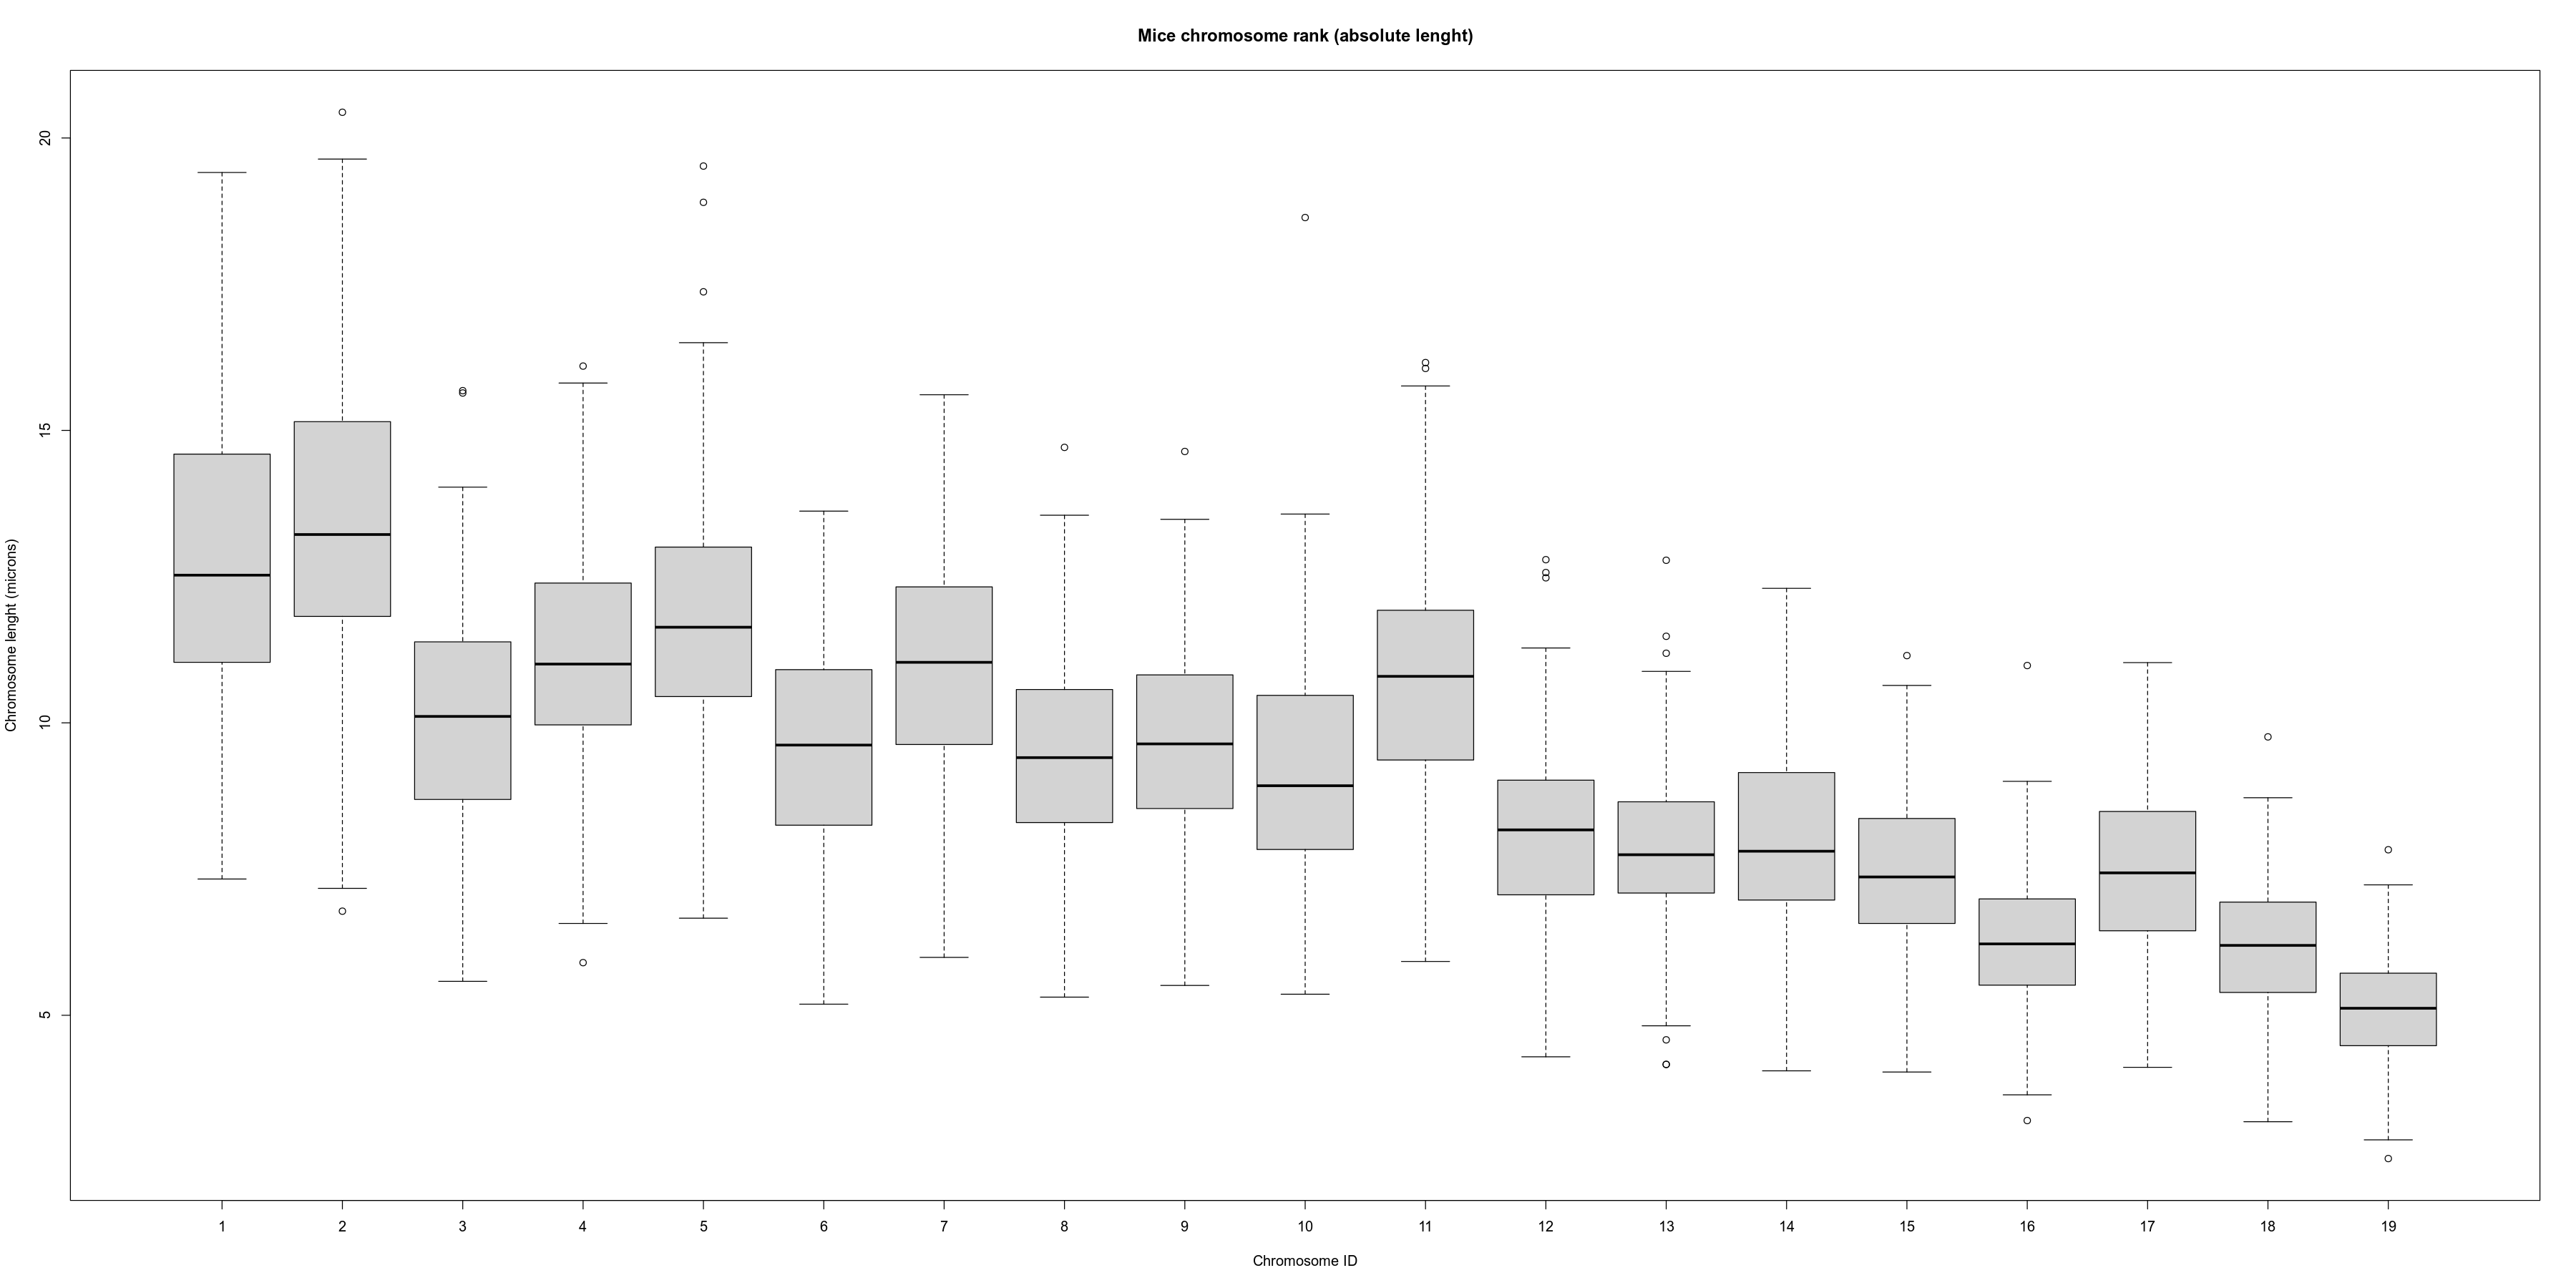

In [100]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Len ~ FITC.Rank, data = data, main = "Mice chromosome rank (absolute lenght)",
   xlab = "Chromosome ID", ylab = "Chromosome lenght (microns)")

Boxplot, relative length (`Rel.len`) by chromosome number (`FITC.Rank`)

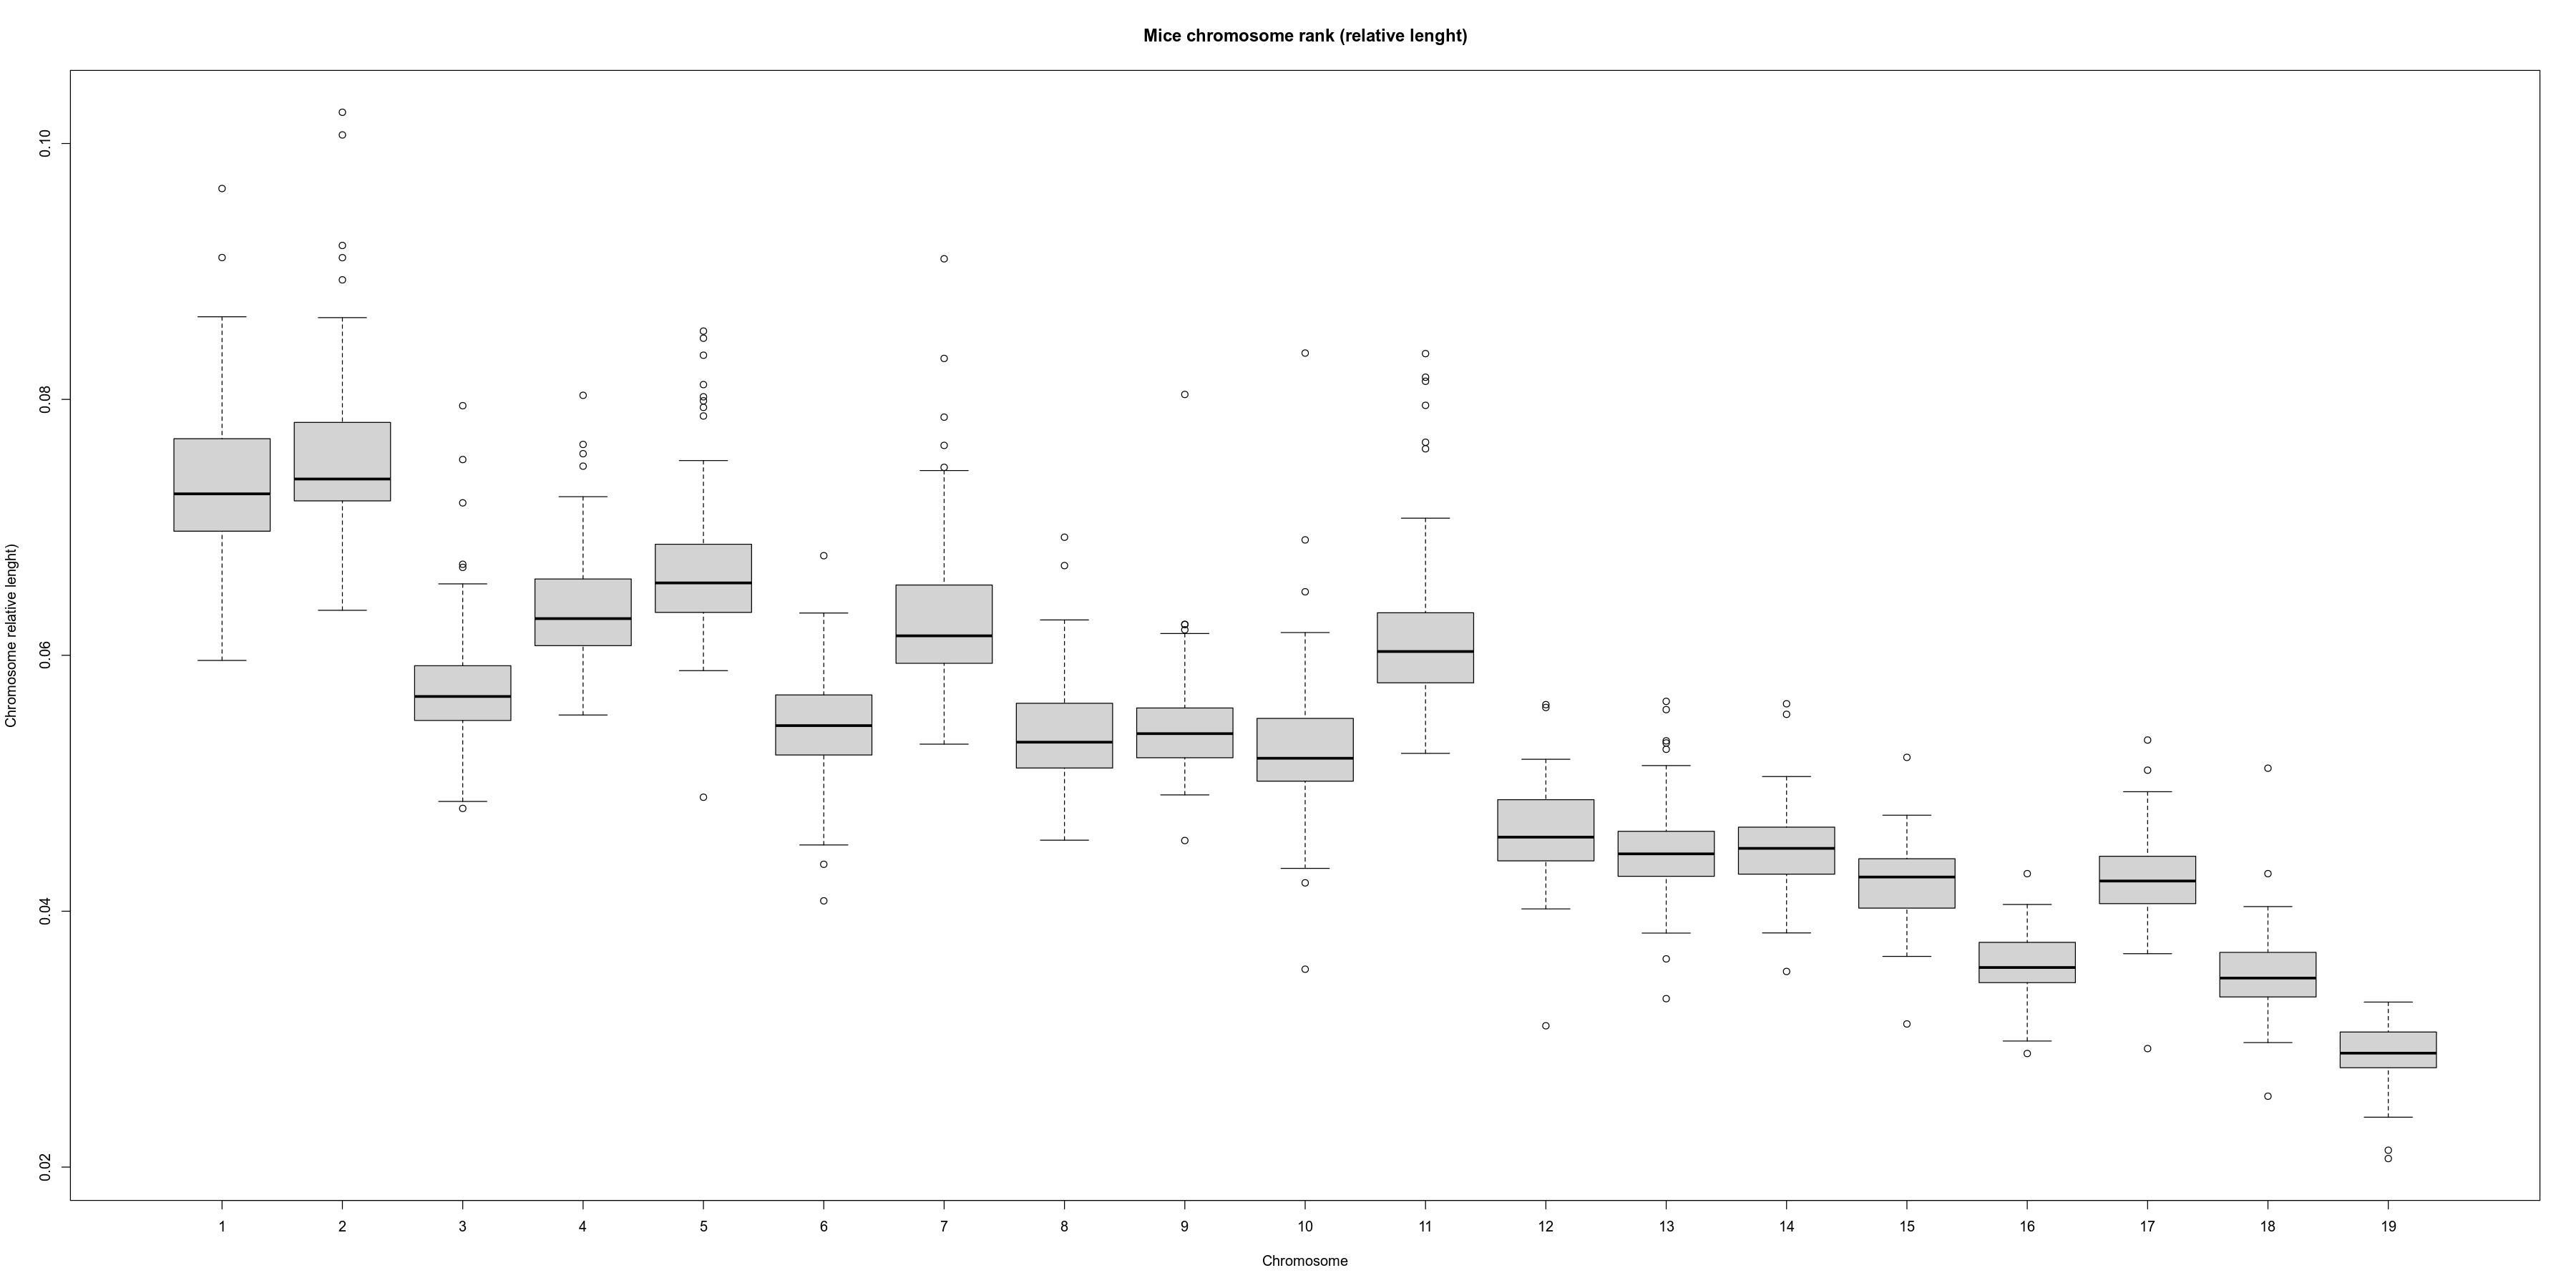

In [101]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Rel.len ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome", ylab = "Chromosome relative lenght)")

Scatterplot, relative length (`Rel.len`) by chromosome number (`FITC.Rank`), hue by mouse specimen (`mouse`).

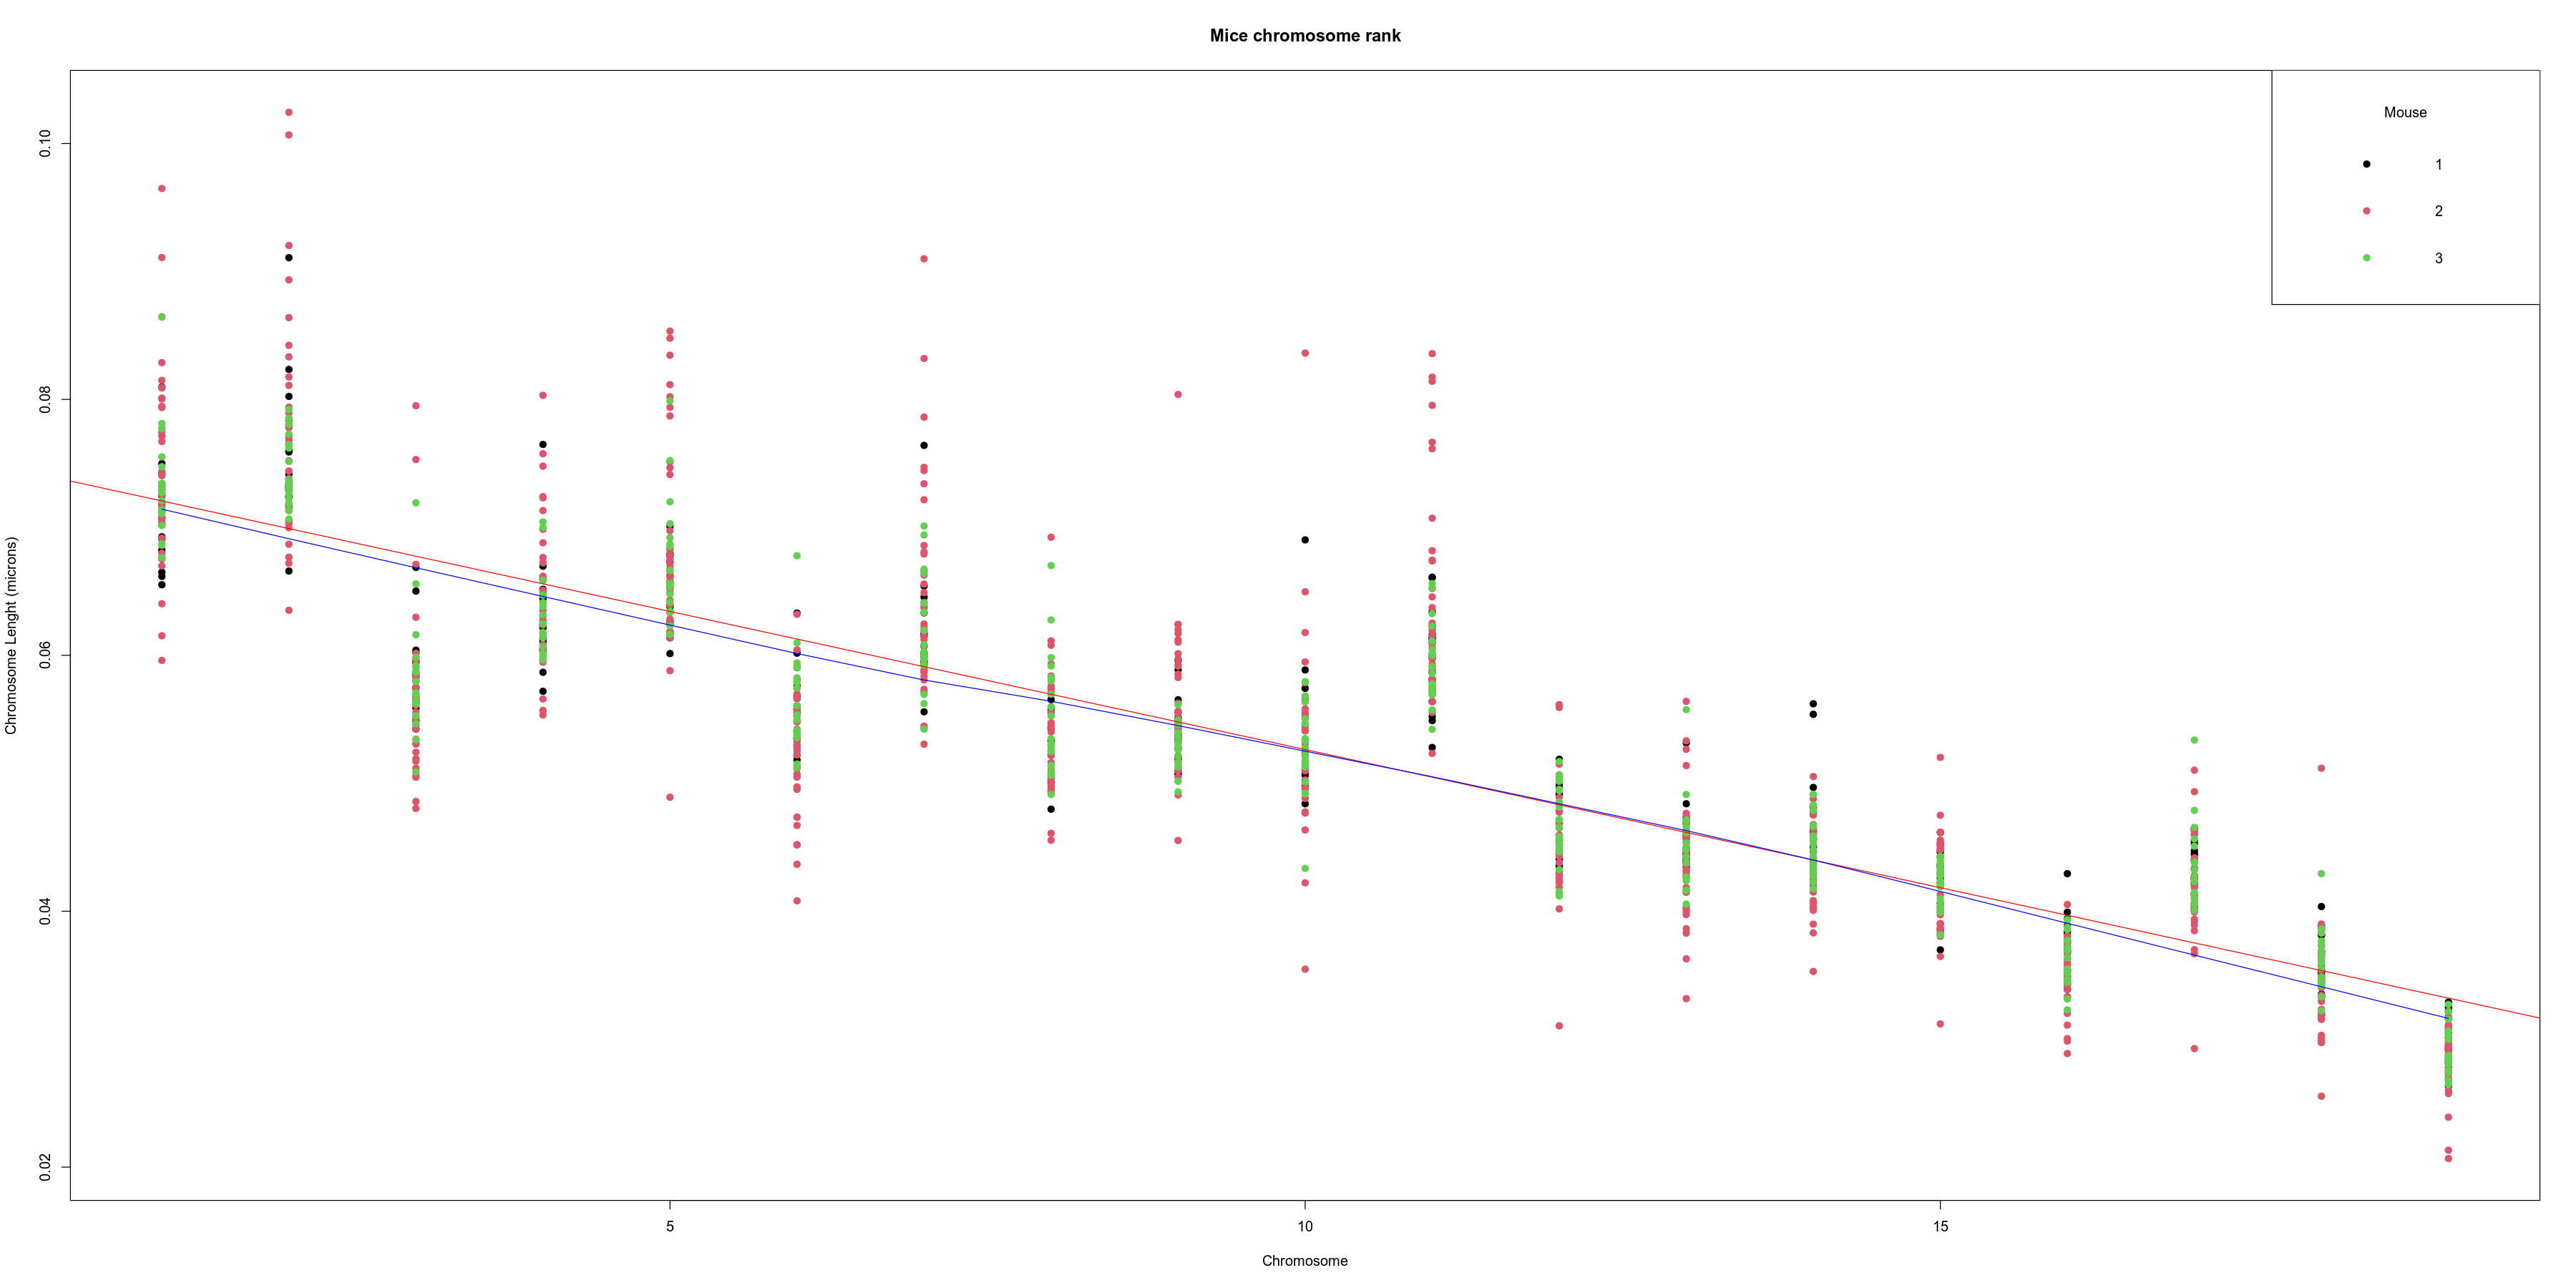

In [102]:
attach(data)
options(repr.plot.width=30, repr.plot.height=15) # Plot size
plot(FITC.Rank, Rel.len, main = "Mice chromosome rank",
   xlab = "Chromosome", ylab = "Chromosome Lenght (microns)", pch = 19,
   col = factor(mouse))

abline(lm(Rel.len ~ FITC.Rank), col = "red") # regression line (y~x)
lines(lowess(FITC.Rank, Rel.len), col = "blue") # lowess line (x,y)

# Legend
legend("topright",
       legend = levels(factor(mouse)),
       pch = 19,
       col = factor(levels(factor(mouse))),
       title = "Mouse")

detach(data) # to avoid masked objects warnings if run more than once

Boxplot, chromosome length rank (`Lgth.Rank`) by chromosome number (`FITC.Rank`)

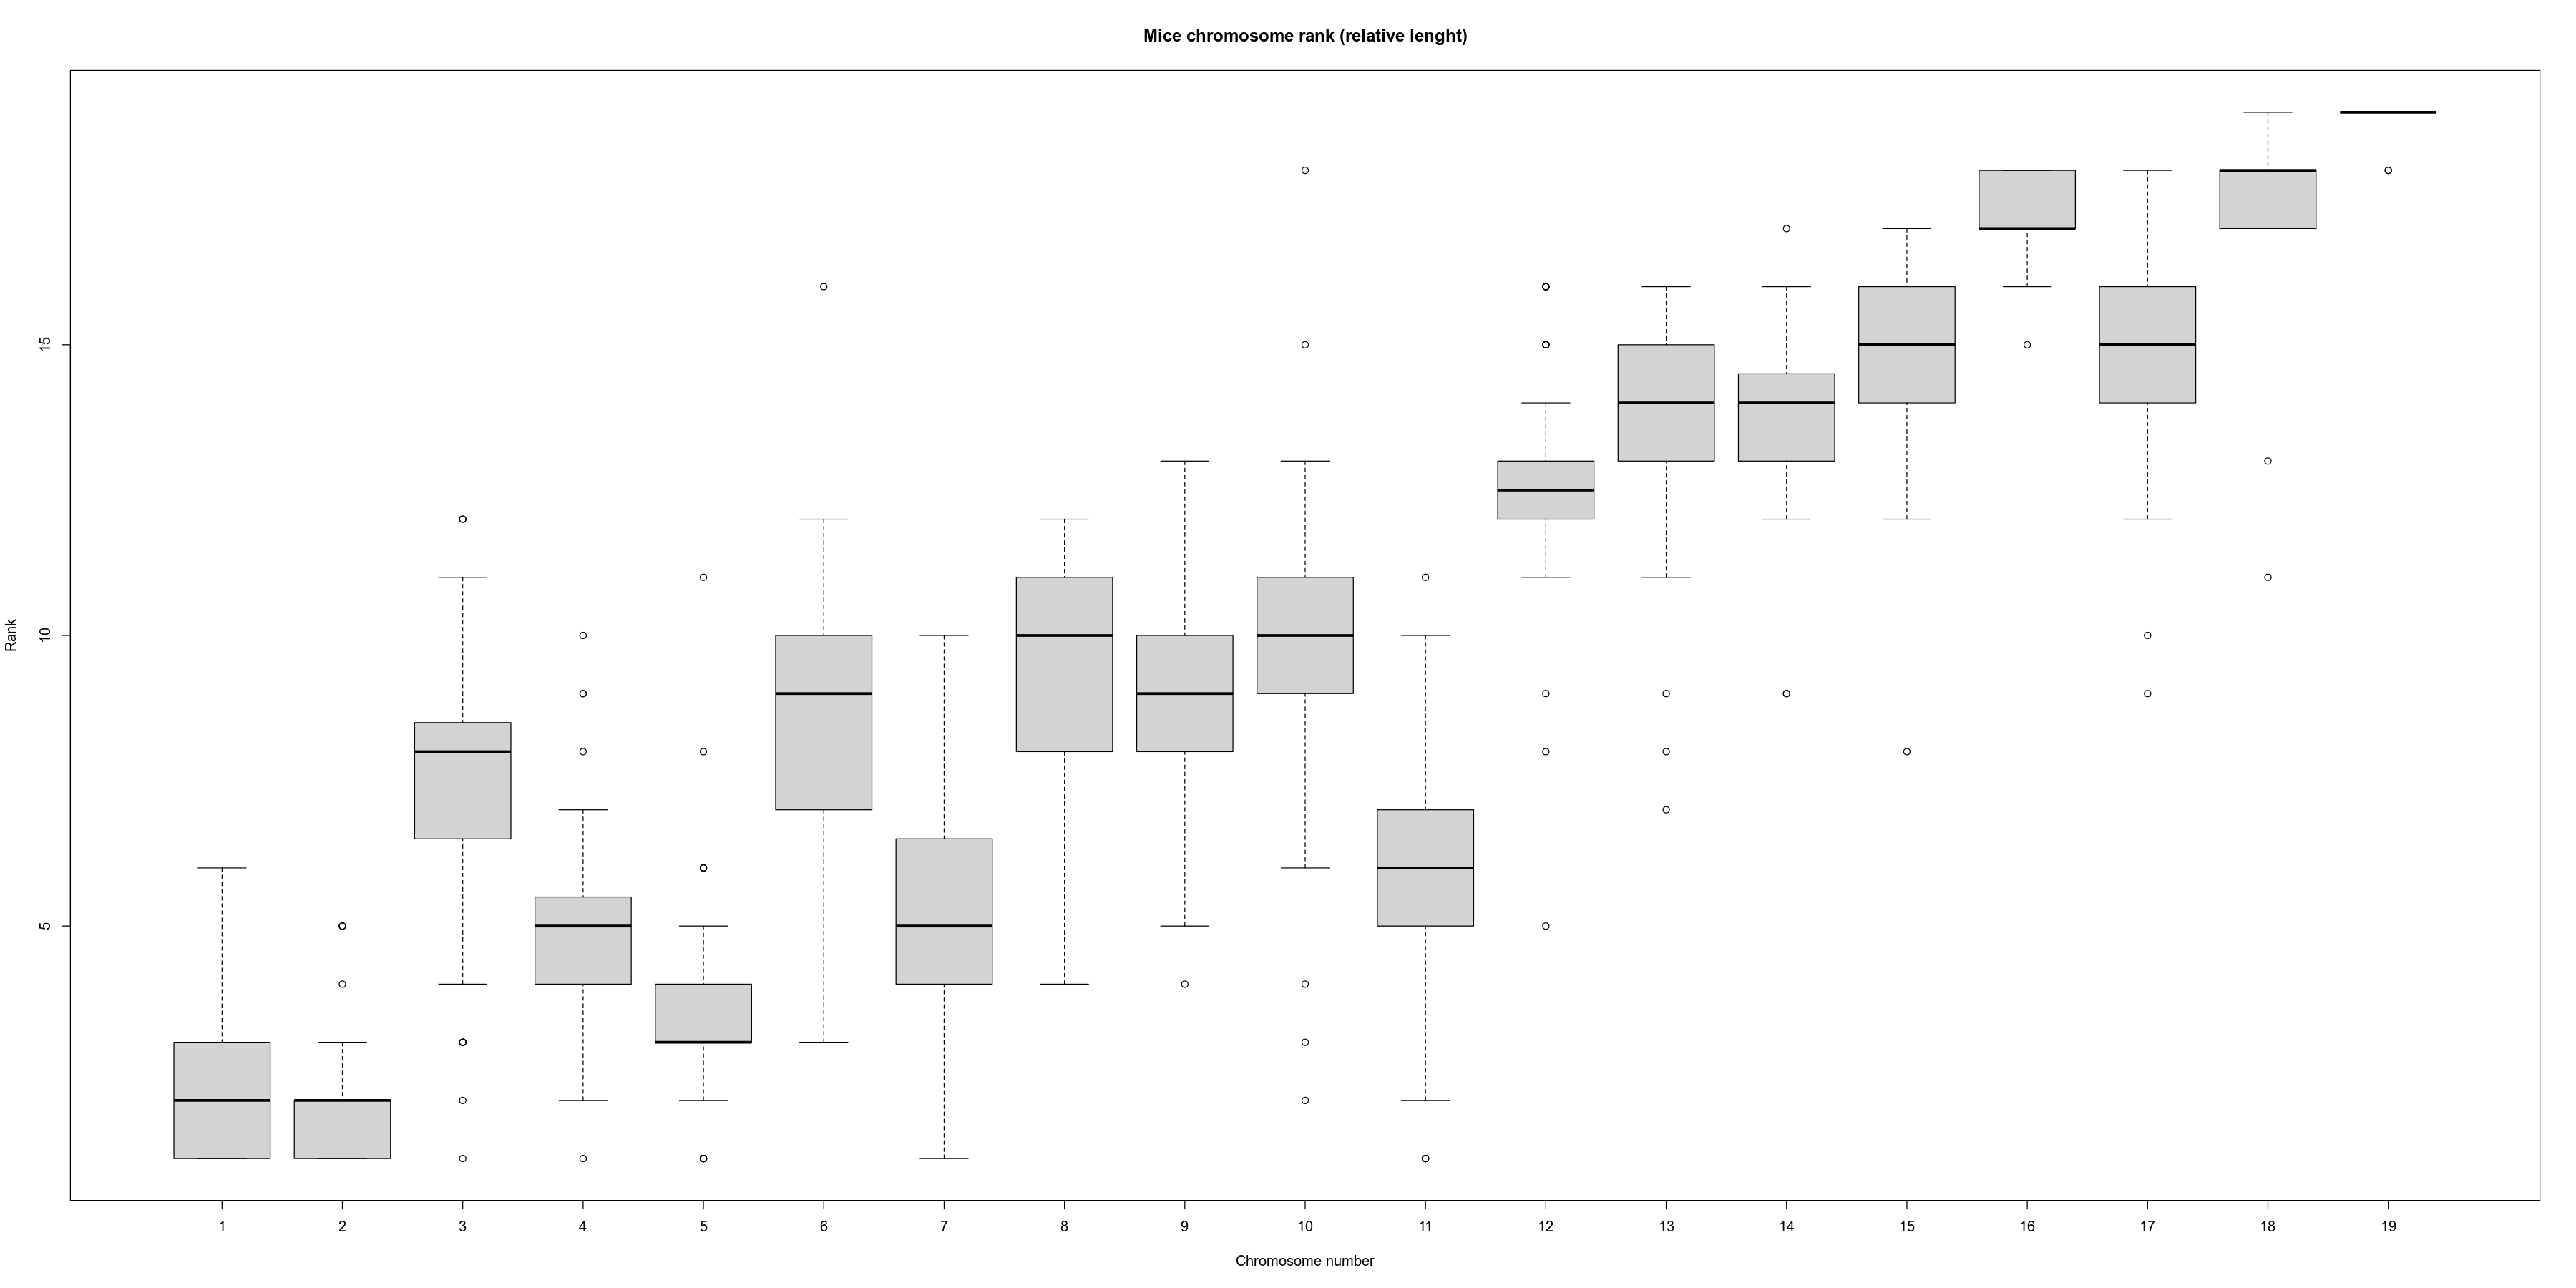

In [103]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot (Lgth.Rank ~ FITC.Rank, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Chromosome number", ylab = "Rank")

Boxplot, relative length (`Rel.len`) by mouse specimen (`mouse`).

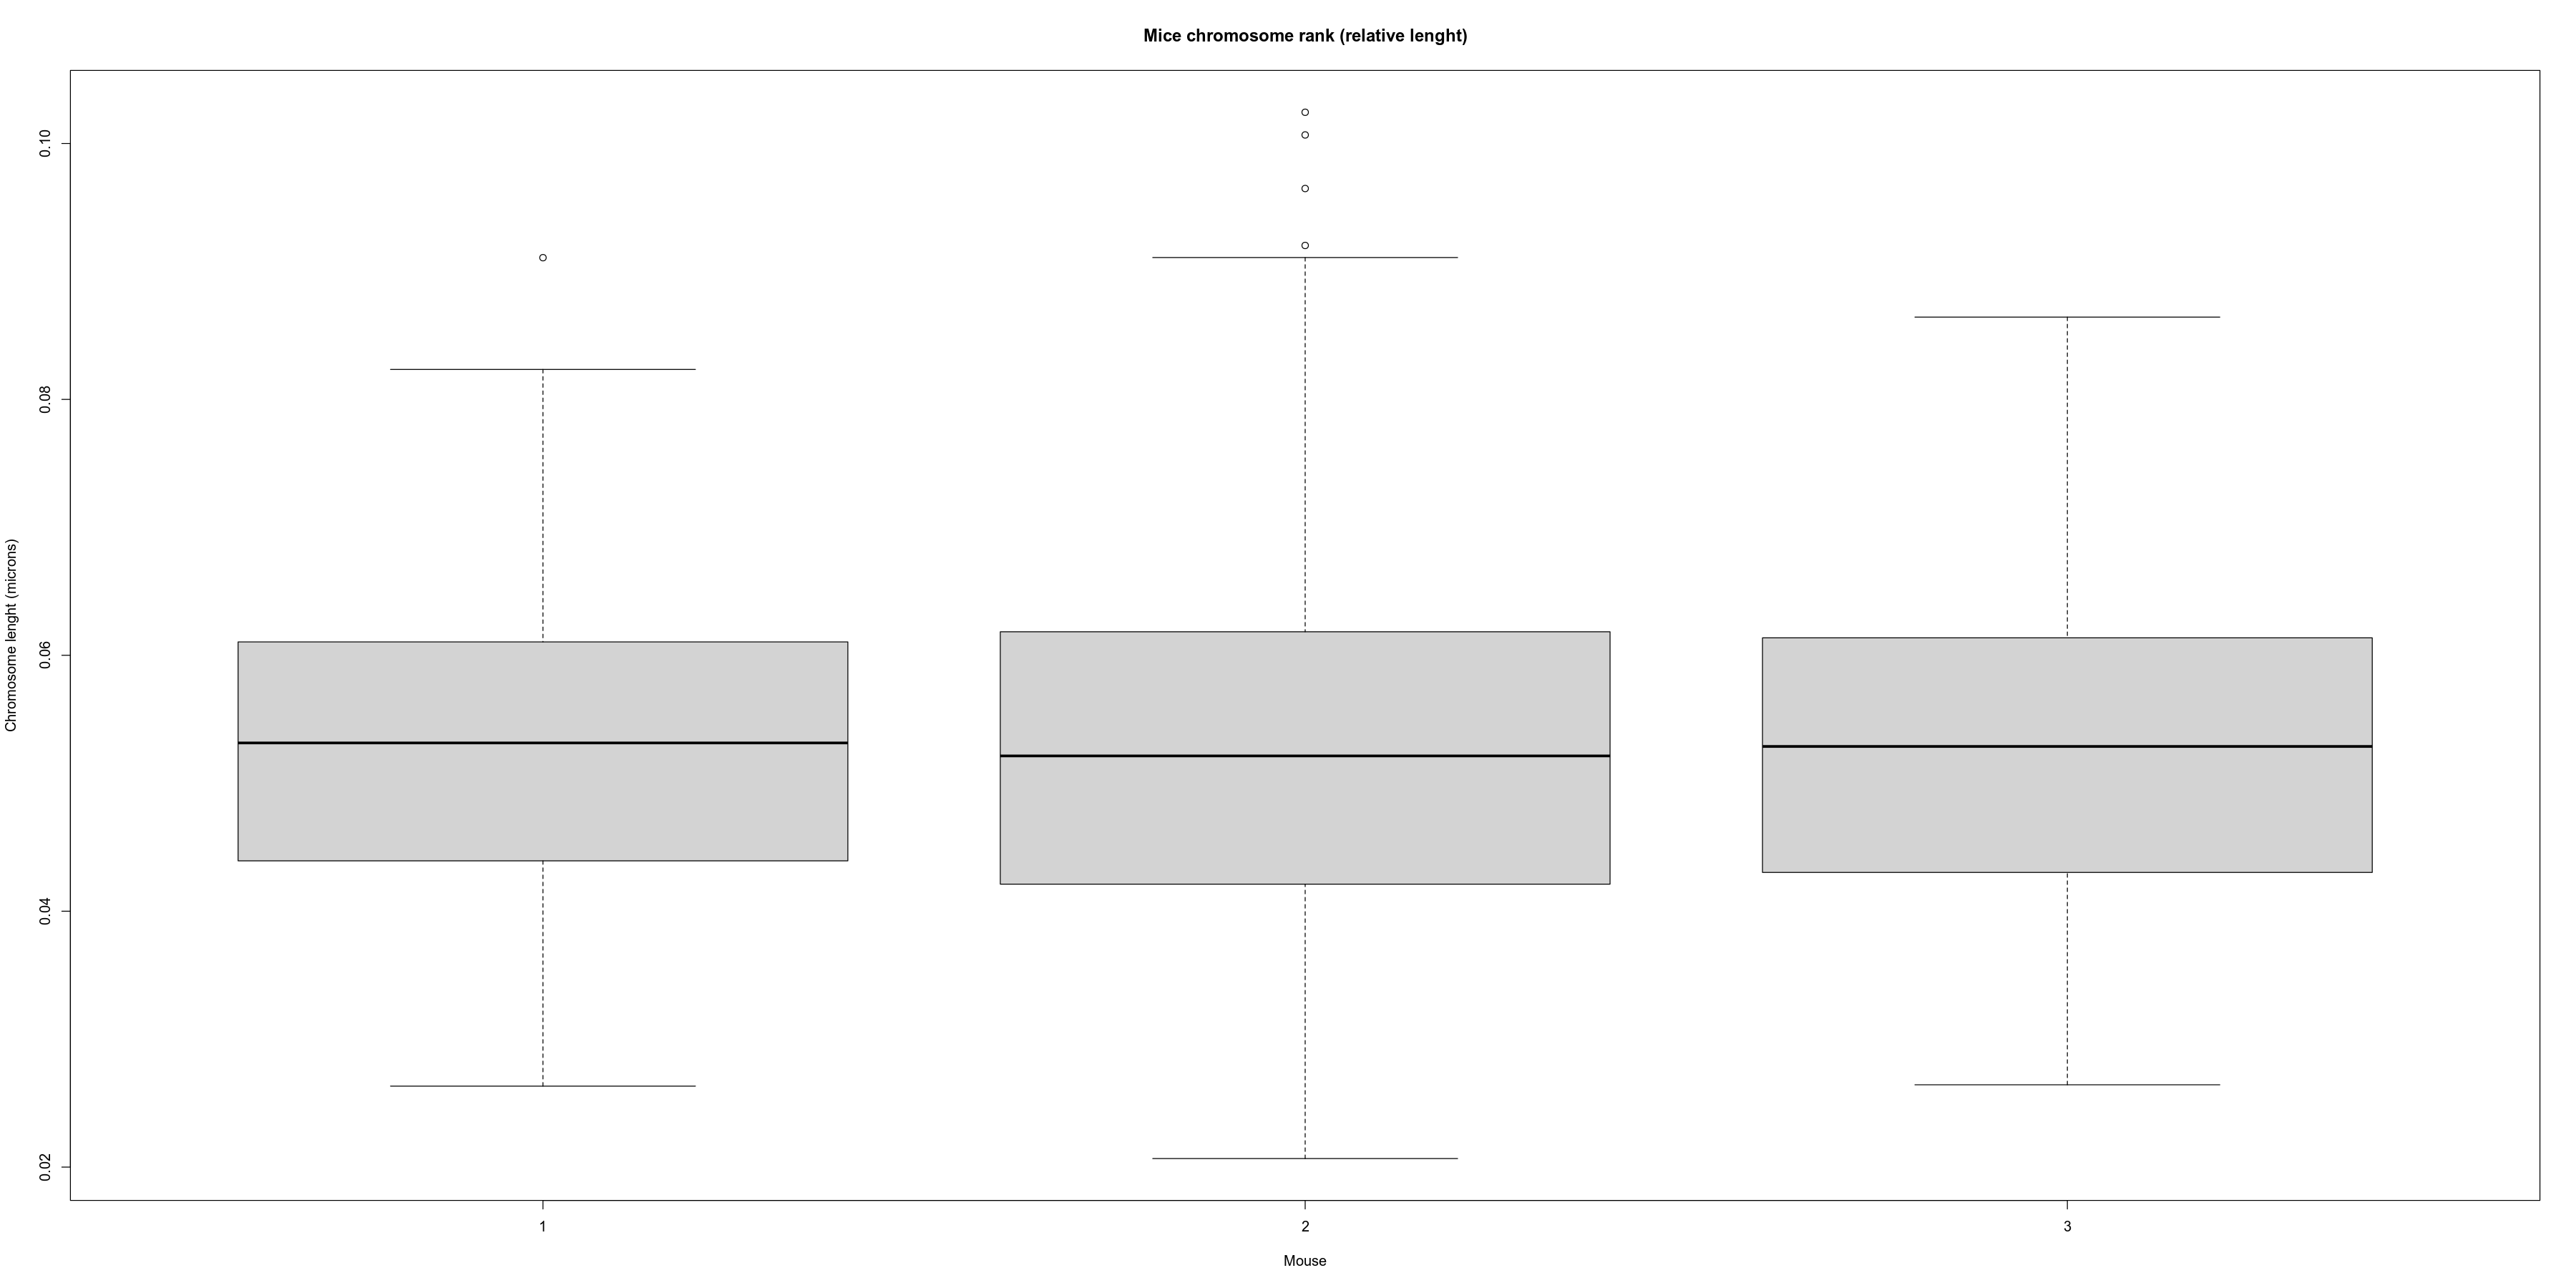

In [104]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size
boxplot(Rel.len ~ mouse, data = data, main = "Mice chromosome rank (relative lenght)",
   xlab = "Mouse", ylab = "Chromosome lenght (microns)")

Scatterplot, chromosome length (`Len`) by cell ID (`Set.ID`), hue by mouse (`mouse`)

In [105]:
# some options for ggplot2
options(repr.plot.width=30, repr.plot.height=12) # Plot size

# install.packages("ggplot2")
library("ggplot2")
attach(data)

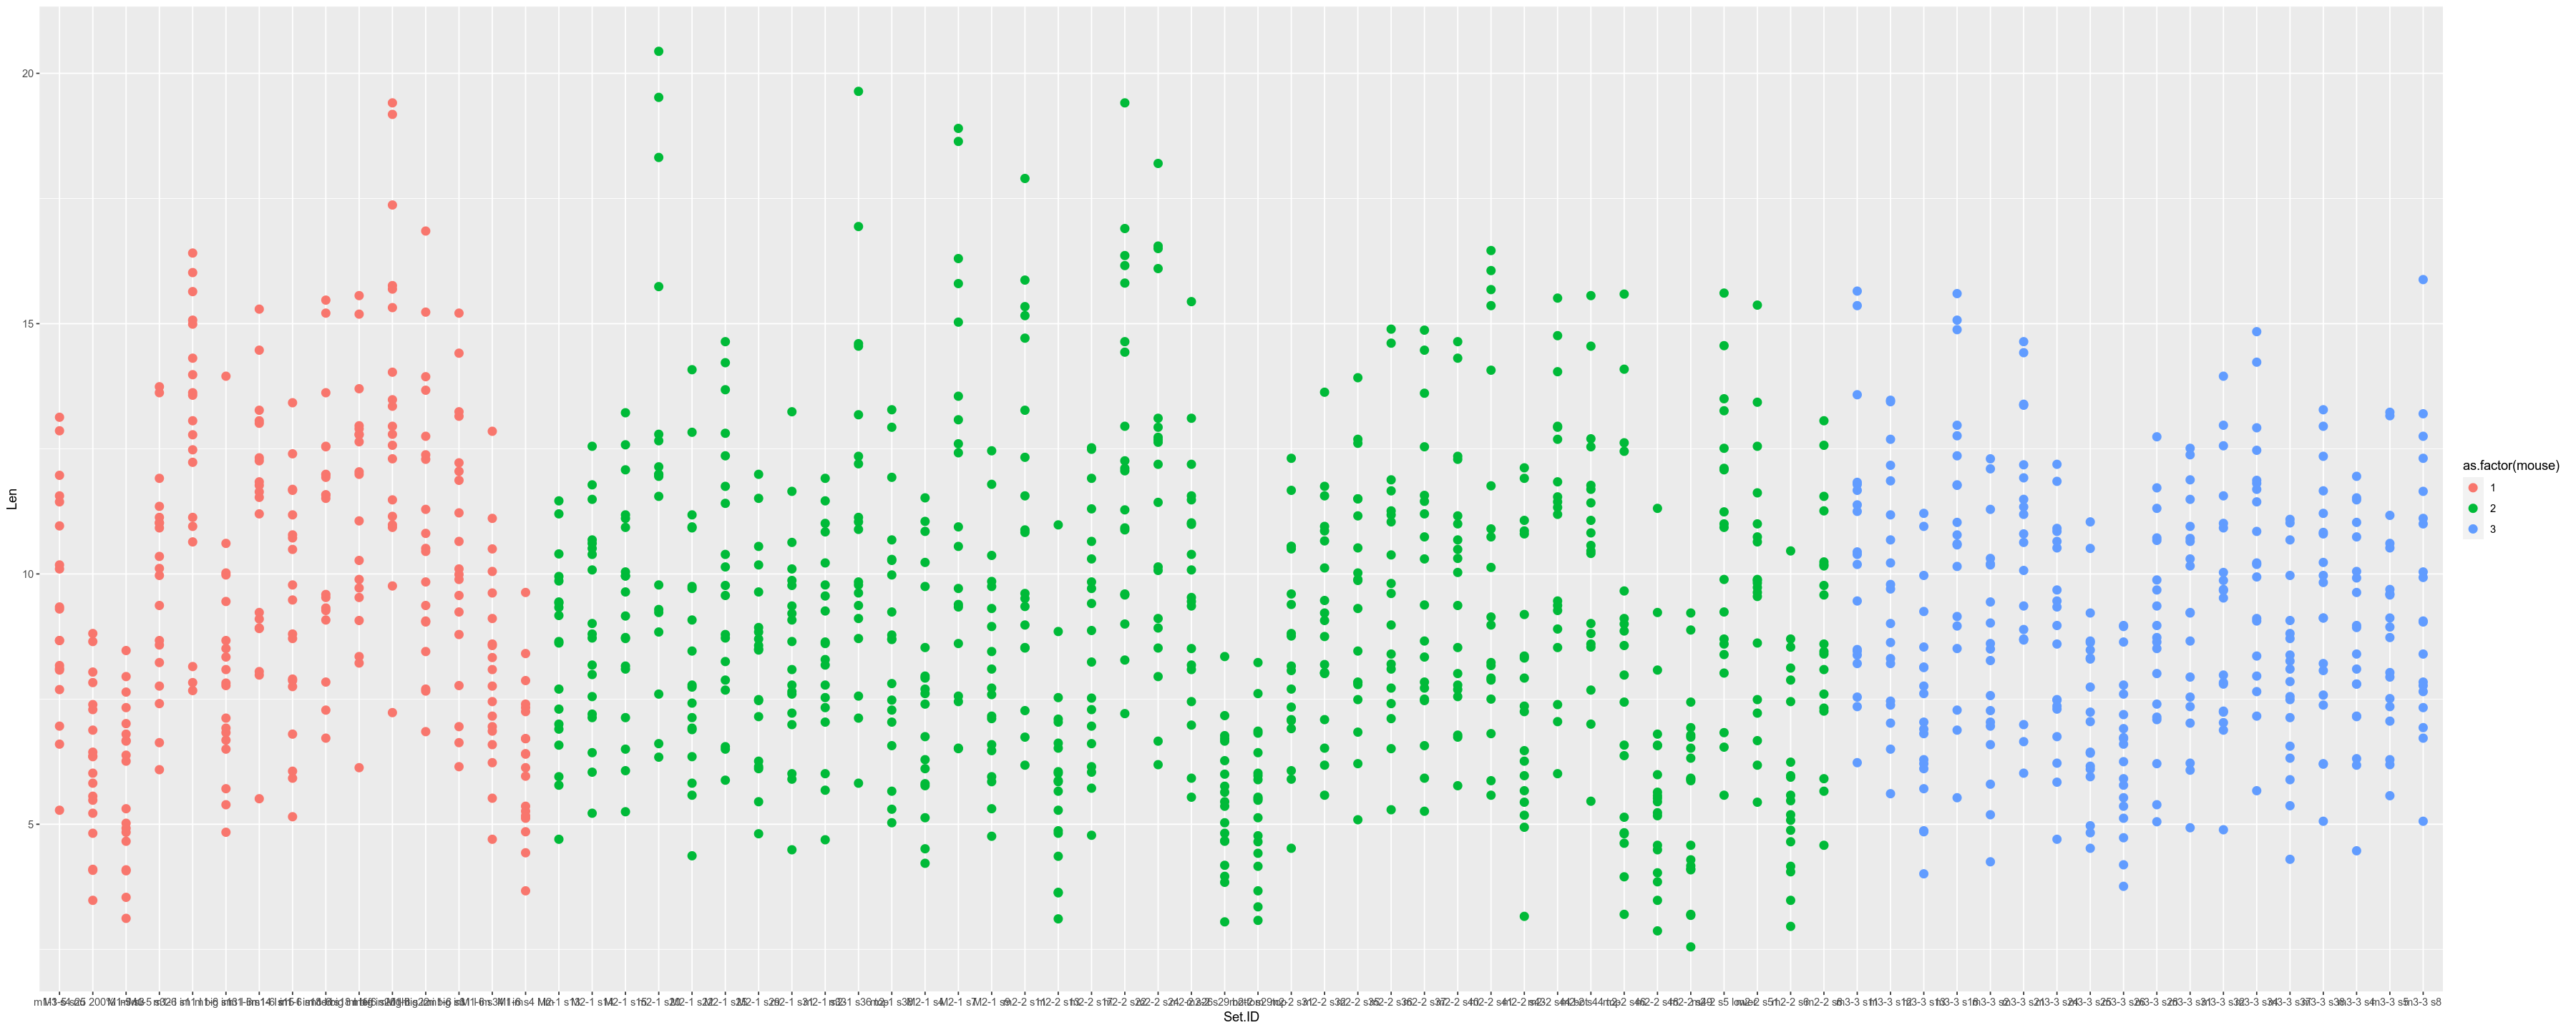

In [106]:
ggplot(data, aes(Set.ID, Len, color = as.factor(mouse))) + geom_point(size=3)

Boxplot, chromosome length (`Len`) by cell ID (`Set.ID`), hue by mouse (`mouse`)

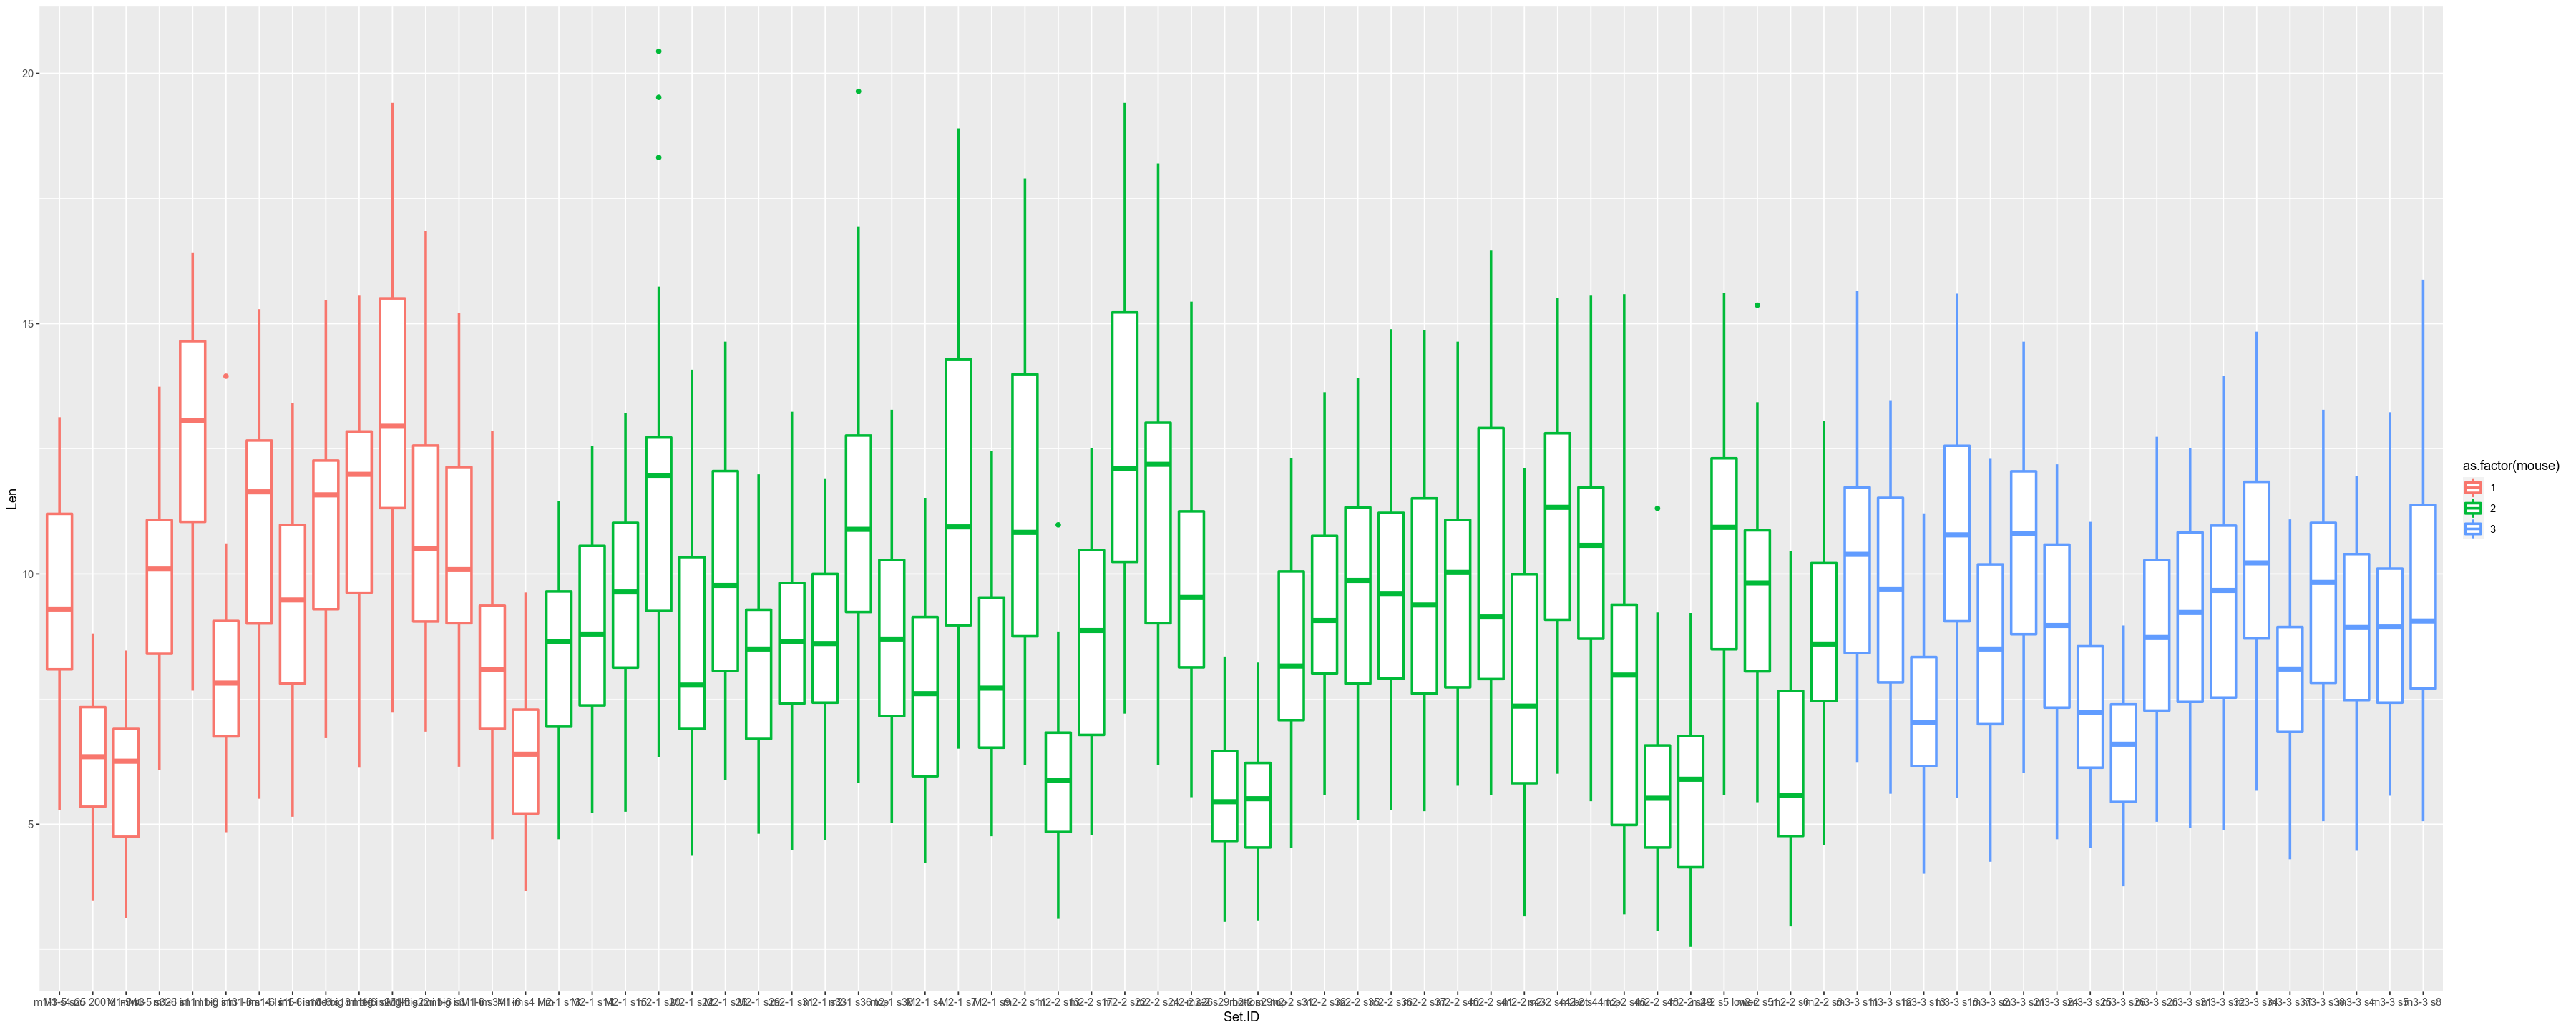

In [107]:
ggplot(data, aes(Set.ID, Len, color = as.factor(mouse))) + geom_boxplot(size=1)

Scatterplot, chromosome length (`Len`) by cell ID (`Set.ID`), hue by chromosome number (`FITC.Rank`)

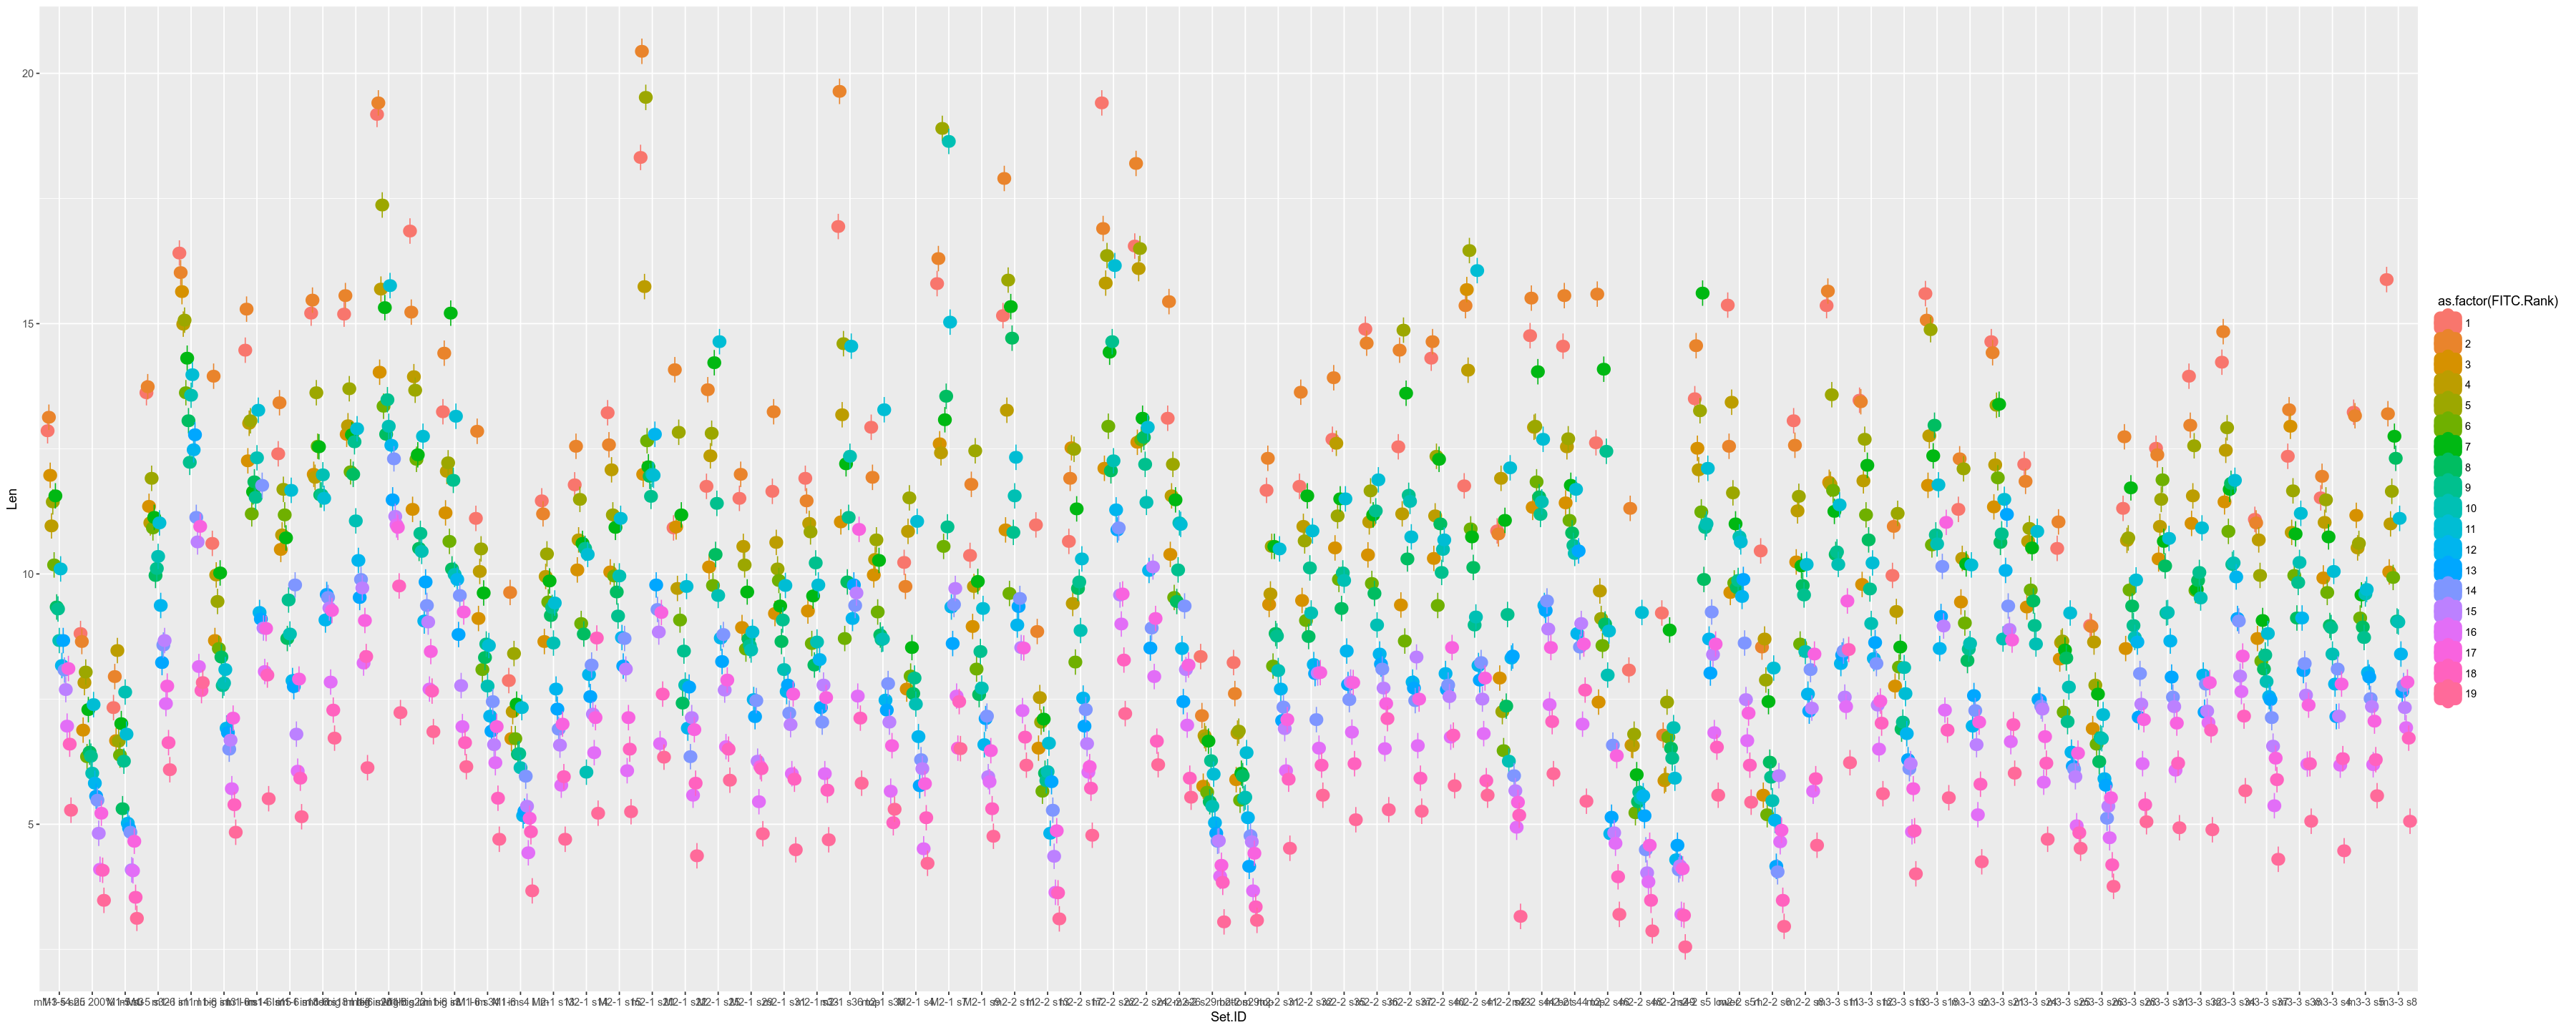

In [108]:
ggplot(data, aes(Set.ID, Len, color = as.factor(FITC.Rank))) + geom_boxplot(size=5)
detach(data)

## Part 1: Manually predefined clusters <a class="anchor" id="manual-clusters"></a>

### Establishing predefined clusters
First of all, we will try if the chromosome length fits a group of 5 predefined and consecutive clusters, as established by previous literature. In the second half of this project, we will use other techniques to establish the optimal number of clusters.

For the predefined groups, we will group the chromosomes the following way:

|   | Chromosome size rank |
|---|----------------------|
| 0 | 1-2                  |
| 1 | 3-5                  |
| 2 | 6-11                 |
| 3 | 12-16                |
| 4 | 17-19                |

(We store these ranges in a new dataframe, for future use: `df_ranks`)

In [109]:
df_ranks <- data.frame("rank_interval" = c(1, 2, 3, 4, 5),
                 "chr_start" = c(1, 3, 6, 12, 17),
                 "chr_end" = c(2, 5, 11, 16, 19))

df_ranks

rank_interval,chr_start,chr_end
<dbl>,<dbl>,<dbl>
1,1,2
2,3,5
3,6,11
4,12,16
5,17,19


### Matching Length rank with chromosome number <a class="anchor" id="rank-matching"></a>

In theory, the chromosome number should match the chromosome length, so the largest chromosome is the #1, the second largest the #2, and so on.

The first step will be checking if the Length rank (`Lgth.Rank`) matches the chromosome number (`FITC.Rank`).
A new column (`Rank.Match`) will be added to the dataframe to store whether the rank matches or not (boolean variable):

In [110]:
data$Rank.Match <- NA
head(data)

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,Rank.Match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,NA
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,NA


In [111]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"FITC.Rank"]] == data[[i,"Lgth.Rank"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$Rank.Match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe
head(data)

[1] FALSE FALSE  TRUE FALSE  TRUE FALSE


,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,Rank.Match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,FALSE
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,FALSE
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,TRUE
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,FALSE
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,TRUE
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,FALSE


### Comparing manually predefined clusters against real chromosome ranks <a class="anchor" id="cluster-rank-comparing"></a>

Now we'll repeat the process, but instead of comparing the ranks directly, we'll assign the two ranks to the rank interval where they belong and compare them. We will assign each chromosome number (`FITC.Rank`) to the predefined group that we created, repeat the same for the chromosome length rank (`Lgth.Rank`), and find out whether they match or not.


We add three more features to our dataset (`data`) to store these data: `FITC.Rank_Group`, `Lgth.Rank_Group`, and `Rank_Group.Match`

In [112]:
data$FITC.Rank_Group <- NA #previously Rank.predicted.Ignasi
data$Lgth.Rank_Group <- NA #previously Rank.real
data$Rank_Group.Match <- NA #previously Rank_interval.Match
head(data)

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,Rank.Match,FITC.Rank_Group,Lgth.Rank_Group,Rank_Group.Match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,FALSE,NA,NA,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,FALSE,NA,NA,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,TRUE,NA,NA,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,FALSE,NA,NA,NA
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,TRUE,NA,NA,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,FALSE,NA,NA,NA


For each chromosome number (`FITC.Rank`), find out to which group (rank_interval) it would correspond.

In [ ]:
results <- vector()

for(i in 1:nrow(data)) {
    cat(paste("\nChromosome", data[[i, "FITC.Rank"]], "from cell", data[[i, "Set.ID"]]))
    for(j in 1:nrow(df_ranks)){
        if ((data[[i,"FITC.Rank"]] >= df_ranks[[j,"chr_start"]]) && (data[[i,"FITC.Rank"]] <= df_ranks[[j,"chr_end"]])){
            cat(" is in rank interval", j)
            results <- c(results, df_ranks[[j, "rank_interval"]])
        }
    }
}
#head(results)
data$FITC.Rank_Group <- results
head(data)

Same, but now with the chromosome length rank (`Lgth.Rank`):

In [ ]:
results <- vector()

for(i in 1:nrow(data)) {
    cat(paste("\nChromosome", data[[i, "Lgth.Rank"]], "from cell", data[[i, "Set.ID"]]))
    for(j in 1:nrow(df_ranks)){
        if ((data[[i,"Lgth.Rank"]] >= df_ranks[[j,"chr_start"]]) && (data[[i,"Lgth.Rank"]] <= df_ranks[[j,"chr_end"]])){
            cat(" is in rank interval", j)
            results <- c(results, df_ranks[[j, "rank_interval"]])
        }
    }
}
#head(results)
data$Lgth.Rank_Group <- results
head(data)

And finally we compare the two (`FITC.Rank_Group` with `Lgth.Rank_Group`):

In [115]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"FITC.Rank_Group"]] == data[[i,"Lgth.Rank_Group"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$Rank_Group.Match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe
head(data)

[1]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE


,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,Rank.Match,FITC.Rank_Group,Lgth.Rank_Group,Rank_Group.Match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,FALSE,1,1,TRUE
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,FALSE,1,1,TRUE
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,TRUE,2,2,TRUE
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,FALSE,2,3,FALSE
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,TRUE,2,2,TRUE
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,FALSE,3,3,TRUE


#### Rank group match rate (%) <a class="anchor" id="cluster-rank-comparing-results"></a>
Now let's count the % of rank groups that matched our predictions:

In [116]:
options(warn=-1) # Hide warning
#install.packages("dplyr") # If necessary. May require to be run from a console (and 'conda install gxx_linux-64' installed)
library(dplyr)
options(warn=0)

globalpercent = sum((data[["Rank_Group.Match"]]) == TRUE)/count(data)*100
globalpercent = globalpercent[[1]]
cat(globalpercent,"% of the chromosomes fit the predicted rank interval.")

71.34503 % of the chromosomes fit the predicted rank interval.

Let's break it down by cell (`Set.ID`):

In [117]:
# Grouped by cell
df_count_cell = count(data,Set.ID, Rank_Group.Match)

df_count_cell$Percent <- NA

percent = vector()
len = length(unique(data$FITC.Rank)) #  Number of distinc values in the column Set.ID
percent = c(percent,df_count_cell$n / len * 100)
df_count_cell$Percent <- percent

df_count_cell <- df_count_cell[!(df_count_cell$Rank_Group.Match == FALSE),] # drop cells with FALSE

summary(df_count_cell['Percent'])
head(df_count_cell)

    Percent     
 Min.   :31.58  
 1st Qu.:63.16  
 Median :68.42  
 Mean   :71.35  
 3rd Qu.:78.95  
 Max.   :89.47  

,Set.ID,Rank_Group.Match,n,Percent
,<chr>,<lgl>,<int>,<dbl>
2,m1-3 s4 nu,TRUE,13,68.42105
4,M1-5 s25 200% im nu,TRUE,15,78.94737
6,M1-5 s3,TRUE,11,57.89474
8,M1-5 s32 I im,TRUE,15,78.94737
10,m1-6 s11 I big im,TRUE,15,78.94737
12,m1-6 s13 I im,TRUE,15,78.94737


And by chromosome number (`FITC.Rank`):

In [118]:
# Grouped by chromosome number
df_count_chr = count(data, Lgth.Rank, Rank_Group.Match)

df_count_chr$Percent <- NA

percent = vector()
len = length(unique(data$Set.ID)) #  Number of distinc values in the column Set.ID
percent = c(percent,df_count_chr$n / len*100)
df_count_chr$Percent <- percent

df_count_chr <- df_count_chr[!(df_count_chr$Rank_Group.Match == FALSE),] # drop cells with FALSE

summary(df_count_cell['Percent'])
df_count_chr

    Percent     
 Min.   :31.58  
 1st Qu.:63.16  
 Median :68.42  
 Mean   :71.35  
 3rd Qu.:78.95  
 Max.   :89.47  

,Lgth.Rank,Rank_Group.Match,n,Percent
,<int>,<lgl>,<int>,<dbl>
2,1,TRUE,59,81.94444
4,2,TRUE,54,75.00000
6,3,TRUE,40,55.55556
8,4,TRUE,45,62.50000
10,5,TRUE,31,43.05556
12,6,TRUE,53,73.61111
14,7,TRUE,50,69.44444
16,8,TRUE,47,65.27778
18,9,TRUE,56,77.77778


#### Plot these results

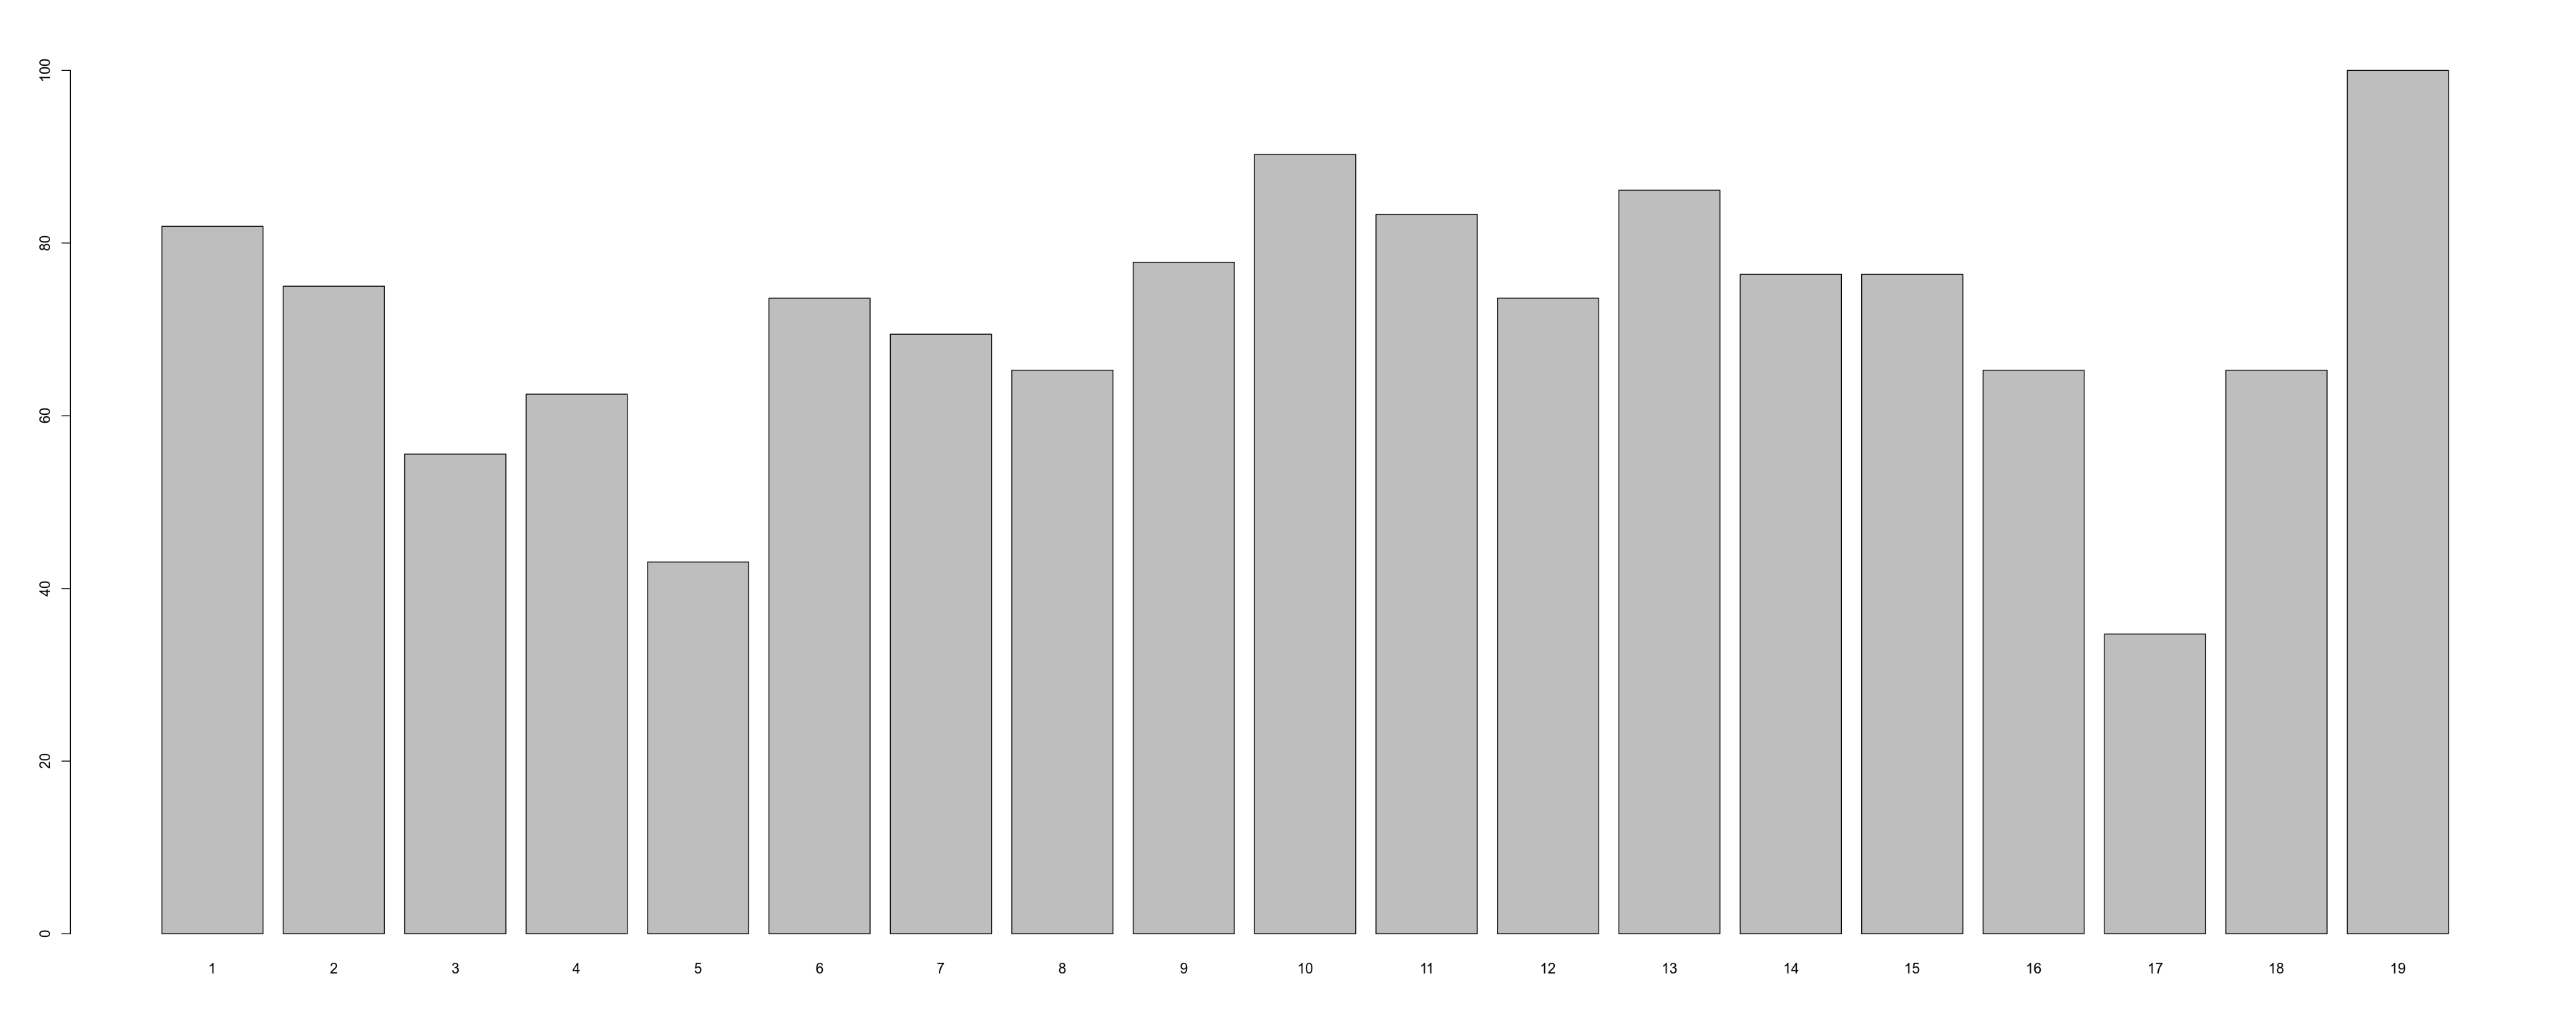

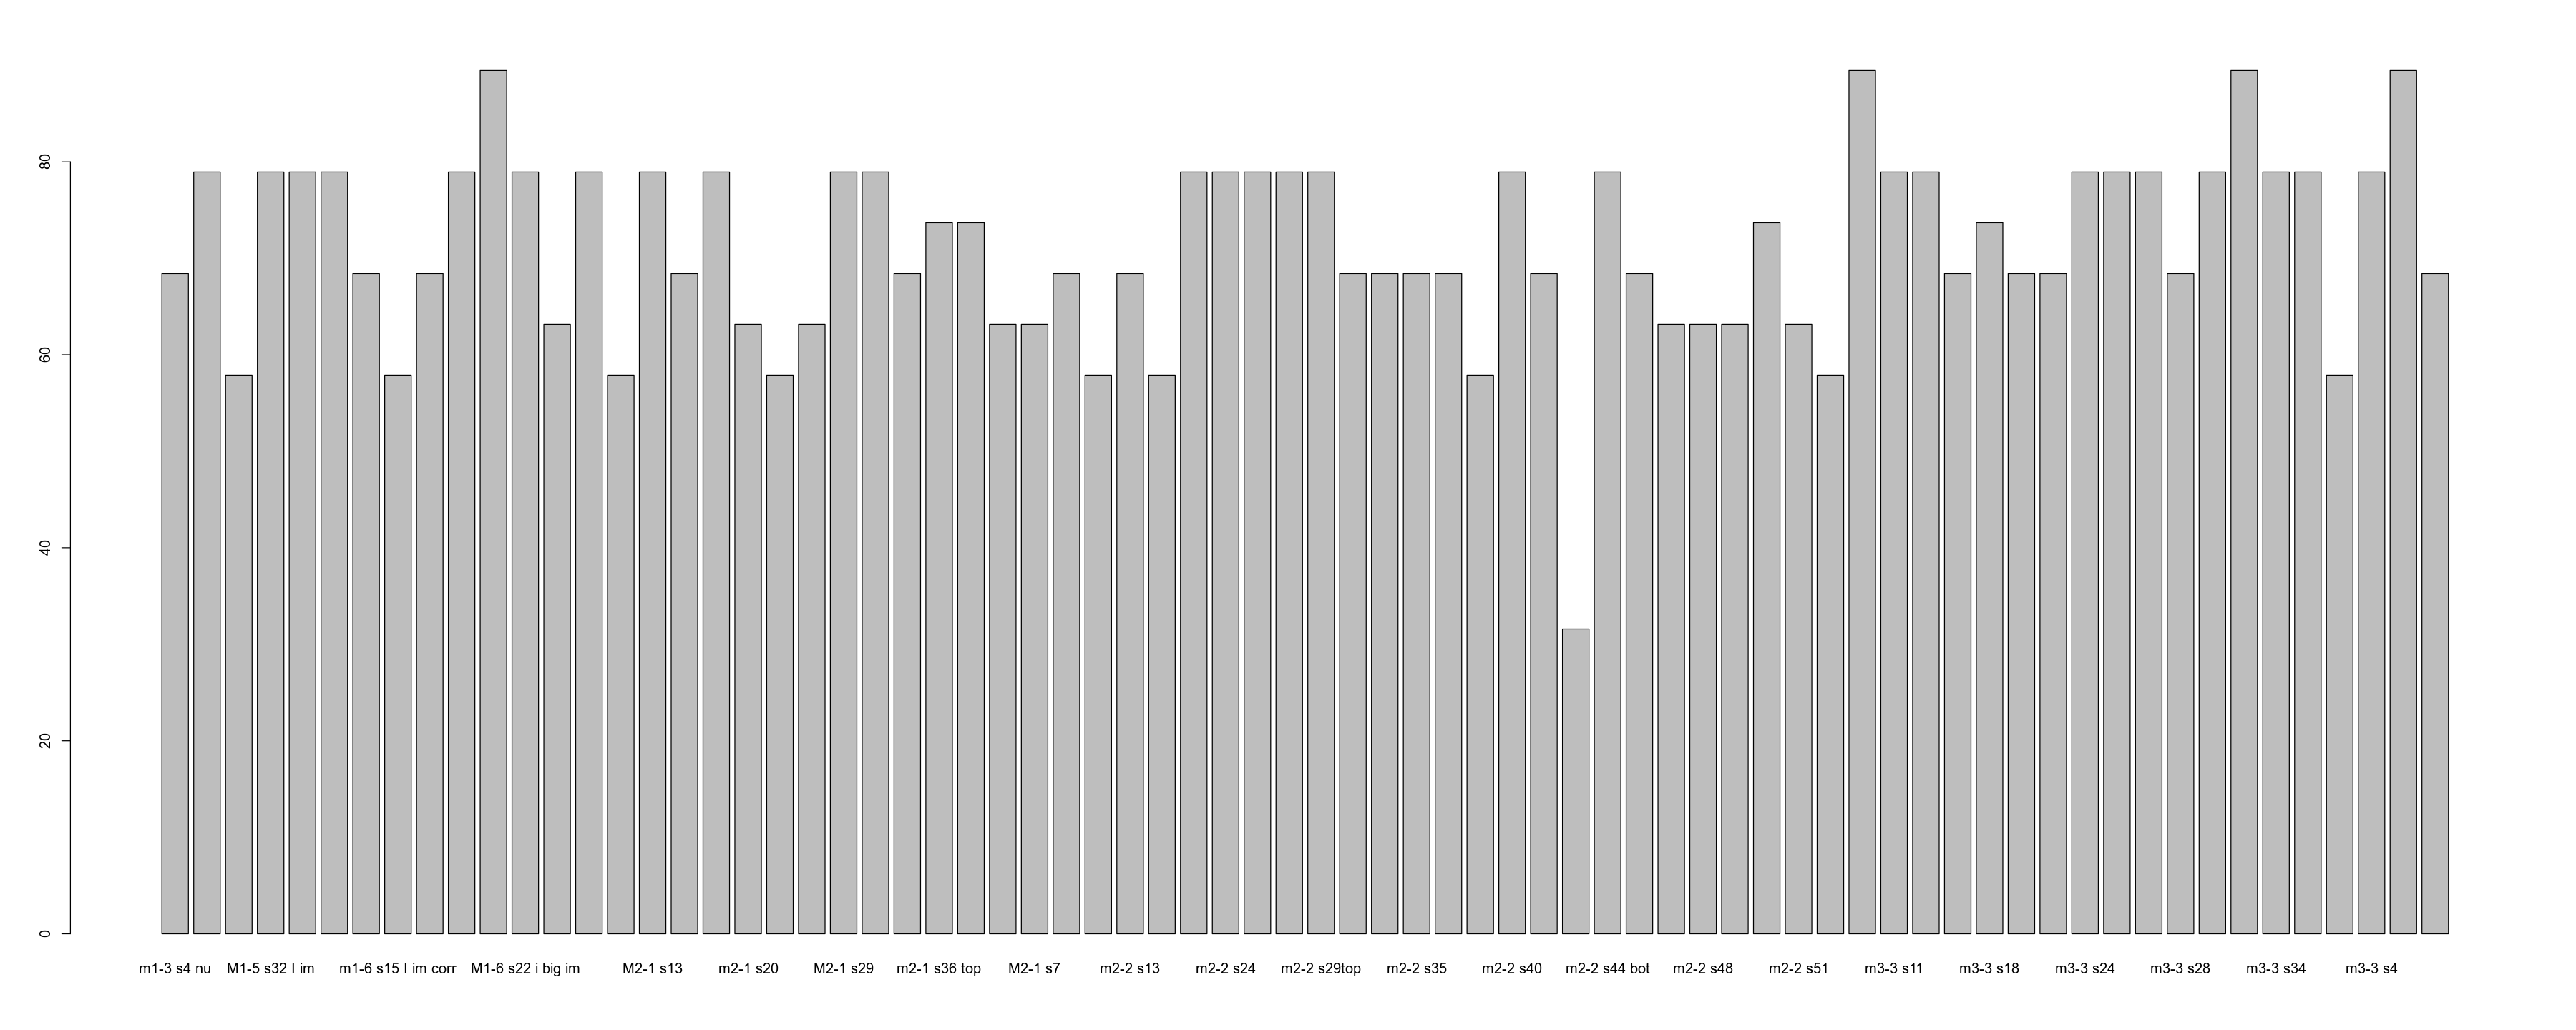

In [119]:
barplot(df_count_chr$Percent, names.arg=df_count_chr$Lgth.Rank)
barplot(df_count_cell$Percent, names.arg=df_count_cell$Set.ID)

As we can observe, when using these predefined and consecutive chromosome groupings, ~71% of the chromosomes seem to fit nicely. It is reasonably high, but it can be improved. In the next section, we'll determine que appropiate number of clusters, and we'll resort to unsupervised clustering via K-Means to make a better assignment of chromosomes to these clusters.

## Part 2: Unsupervised chromosome clustering by relative length <a class="anchor" id="unsupervised-chromosome-clusters"></a>

### Finding out the optimal number of clusters <a class="anchor" id="optimal-cluster-number"></a>
In the previous section we used K=5 as the number of clusters. Now we'll determine if that value was appropiate or not. The main tool will be the *Elbow method* graph, but we'll also make use of the *Silhouette method* and the *Gap statistic* to confirm that value. 

#### Preparing new dataframes:

We'll prepare the data in another format. A new will be created, where each row corresponds to each one of the cells (`Set.ID`), and each column is the relative length (`Rel.len`) of the chromosome. Therefore, its dimensions will be 72x19.

In [120]:
remove(data_chr)

data_chr <- data.frame(matrix(ncol = 0, nrow = 72)) # New dataframe with 0 columns and 72 rows
data_setid = data[data['FITC.Rank'] == 1, ]['Set.ID'] # Cell name for each row

rownames(data_chr) <- data_setid$Set.ID # Set cell names as row names

#head(data_chr)


for(i in 1:max(data['FITC.Rank'])){
   data_chri <- data[data['FITC.Rank'] == i, ]['Rel.len'] # dataframe for just chromosome i and Relative lenght
   head(data_chri)
   colname <- paste("chr",  "_", i, sep="")
   colnames(data_chri) <- c(colname)
   data_chr <- cbind(data_chr, Chr1 = data_chri)
}

head(data_chr)

,chr_1,chr_2,chr_3,chr_4,chr_5,chr_6,chr_7,chr_8,chr_9,chr_10,chr_11,chr_12,chr_13,chr_14,chr_15,chr_16,chr_17,chr_18,chr_19
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1-3 s4 nu,0.07181488,0.07332749,0.06686973,0.06120195,0.06388799,0.05684487,0.06454571,0.05218385,0.05194977,0.04839435,0.05638663,0.04560650,0.04840017,0.04514794,0.04294018,0.03885597,0.04529196,0.03684251,0.02950755
M1-5 s25 200% im nu,0.07423803,0.07289955,0.05797476,0.06600863,0.06776698,0.05351623,0.06149446,0.05428805,0.05365397,0.05072373,0.06230845,0.04909638,0.04690260,0.04621895,0.04060671,0.03460567,0.04400270,0.03439514,0.02929897
M1-5 s3,0.06616516,0.07177734,0.06025146,0.07648032,0.06013468,0.05760277,0.06331358,0.04796924,0.05652113,0.06901942,0.06139199,0.04530324,0.04443659,0.04367428,0.03697767,0.03677593,0.04206872,0.03198613,0.02815037
M1-5 s32 I im,0.07247781,0.07315966,0.06040350,0.05867513,0.06338719,0.05813895,0.05922439,0.05304315,0.05379115,0.05509515,0.05866392,0.04985432,0.04379789,0.04565418,0.04615515,0.03941744,0.04131270,0.03531170,0.03243662
m1-6 s11 I big im,0.06821410,0.06658921,0.06502067,0.06230622,0.06266721,0.05663123,0.05947835,0.05430311,0.05086237,0.05639818,0.05812957,0.05187380,0.05314977,0.04626517,0.04423950,0.03389015,0.04552246,0.03189697,0.03256195
m1-6 s13 I im,0.06926172,0.09107591,0.05660622,0.06515490,0.06171065,0.05554052,0.06541675,0.05446307,0.05069808,0.05104729,0.05279507,0.04516327,0.04460430,0.04239561,0.04358979,0.03724646,0.04644555,0.03518729,0.03159758


Transpose the data and save it into a new dataframe `data_chr_transpose `, since we want to group chromosomes, not cells.

In [121]:
# transpose the data, since we want to group chromosomes, not cells
data_chr_transpose <- as.data.frame(t(as.matrix(data_chr))) 
head(data_chr_transpose)

,m1-3 s4 nu,M1-5 s25 200% im nu,M1-5 s3,M1-5 s32 I im,m1-6 s11 I big im,m1-6 s13 I im,m1-6 s14 I im,m1-6 s15 I im corr,m1-6 s18 I big im left,m1-6 s18 I big im-right,⋯,m3-3 s26,m3-3 s28,m3-3 s31,m3-3 s32,m3-3 s34,m3-3 s37,m3-3 s38,m3-3 s4,m3-3 s5,m3-3 s8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr_1,0.07181488,0.07423803,0.06616516,0.07247781,0.06821410,0.06926172,0.06910275,0.07020489,0.07293312,0.07070936,⋯,0.07308402,0.06762872,0.07137805,0.07811411,0.07207745,0.07270626,0.06859766,0.06872517,0.07771221,0.08643069
chr_2,0.07332749,0.07289955,0.07177734,0.07315966,0.06658921,0.09107591,0.07302975,0.07599537,0.07414206,0.07243904,⋯,0.07297226,0.07619723,0.07065261,0.07258807,0.07514555,0.07225271,0.07372841,0.07130032,0.07729449,0.07188475
chr_3,0.06686973,0.05797476,0.06025146,0.06040350,0.06502067,0.05660622,0.05855709,0.05943591,0.05748871,0.05955204,⋯,0.05633274,0.05088306,0.05878843,0.06160697,0.05795584,0.05706016,0.07191406,0.05921083,0.06558197,0.05464649
chr_4,0.06120195,0.06600863,0.07648032,0.05867513,0.06230622,0.06515490,0.06214521,0.06104691,0.05718657,0.06033423,⋯,0.07042623,0.06379898,0.06247677,0.06470165,0.06316887,0.06998517,0.06014828,0.06582258,0.06178992,0.05987722
chr_5,0.06388799,0.06776698,0.06013468,0.06338719,0.06266721,0.06171065,0.06240982,0.06622637,0.06529225,0.06379692,⋯,0.06336385,0.06414078,0.06558084,0.07029196,0.06542715,0.06536404,0.06477363,0.06849884,0.06230284,0.06343320
chr_6,0.05684487,0.05351623,0.05760277,0.05813895,0.05663123,0.05554052,0.05351671,0.06330382,0.06016536,0.05605017,⋯,0.05378717,0.05787241,0.06778443,0.05411108,0.05493619,0.05413906,0.05536149,0.05745068,0.05355971,0.05407800


And finally, we scale the data so all values measure on the same scale and save it to `data_chr_transpose_scaled`.

In [123]:
# Standardize the data
data_chr_transpose_scaled <- scale(data_chr_transpose)
head(data_chr_transpose_scaled)

,m1-3 s4 nu,M1-5 s25 200% im nu,M1-5 s3,M1-5 s32 I im,m1-6 s11 I big im,m1-6 s13 I im,m1-6 s14 I im,m1-6 s15 I im corr,m1-6 s18 I big im left,m1-6 s18 I big im-right,⋯,m3-3 s26,m3-3 s28,m3-3 s31,m3-3 s32,m3-3 s34,m3-3 s37,m3-3 s38,m3-3 s4,m3-3 s5,m3-3 s8
chr_1,1.5850728,1.67306670,0.9584992,1.7433980,1.3953117,1.1892863,1.37848768,1.3182749,1.7219460,1.5689463,⋯,1.65725625,1.1847776,1.4475181,1.9092925,1.5788171,1.6317237,1.2206300,1.3077458,1.97871271,2.29527129
chr_2,1.7100559,1.56942287,1.3559754,1.8032953,1.2498135,2.7493048,1.70714217,1.7526523,1.8244872,1.7190626,⋯,1.64820050,1.8616920,1.3915027,1.4952507,1.8279172,1.5948582,1.6128832,1.5170001,1.94575719,1.30746816
chr_3,1.1764658,0.41374235,0.5396692,0.6827263,1.1093616,0.2842421,0.49591168,0.5104323,0.4119749,0.6006170,⋯,0.29990399,-0.1381333,0.4754040,0.6724858,0.4322789,0.3599669,1.4741738,0.5346219,1.02170856,0.13683087
chr_4,0.7081504,1.03583359,1.6890582,0.5308978,0.8663003,0.8955915,0.79620472,0.6312822,0.3863473,0.6685026,⋯,1.44189652,0.8822273,0.7602010,0.9043566,0.8555261,1.4105461,0.5746629,1.0718847,0.72253842,0.49204570
chr_5,0.9300914,1.17198949,0.5313981,0.9448295,0.8986244,0.6492798,0.81835002,1.0198238,1.0738594,0.9690249,⋯,0.86963376,0.9092297,0.9998835,1.3232135,1.0388767,1.0349284,0.9282778,1.2893547,0.76300497,0.73352984
chr_6,0.3481347,0.06850193,0.3520788,0.4837970,0.3581427,0.2080296,0.07407742,0.8005862,0.6390038,0.2966945,⋯,0.09363691,0.4140267,1.1700346,0.1108521,0.1871120,0.1225325,0.2087055,0.3915941,0.07322412,0.09822504


#### Graphical methods <a class="anchor" id="graphical-methods"></a>

Elbow Method

In [122]:
# Install the required packages if necessary
pkgs <- c("factoextra",  "NbClust") 
#install.packages(pkgs)
# Alternatives:
#conda install -c conda-forge r-factoextra
#sudo apt-get install r-cran-factoextra

library(factoextra)
library(NbClust)

By running the elbow method below, we can clearly see that **5** was the correct number of clusters for this dataset.

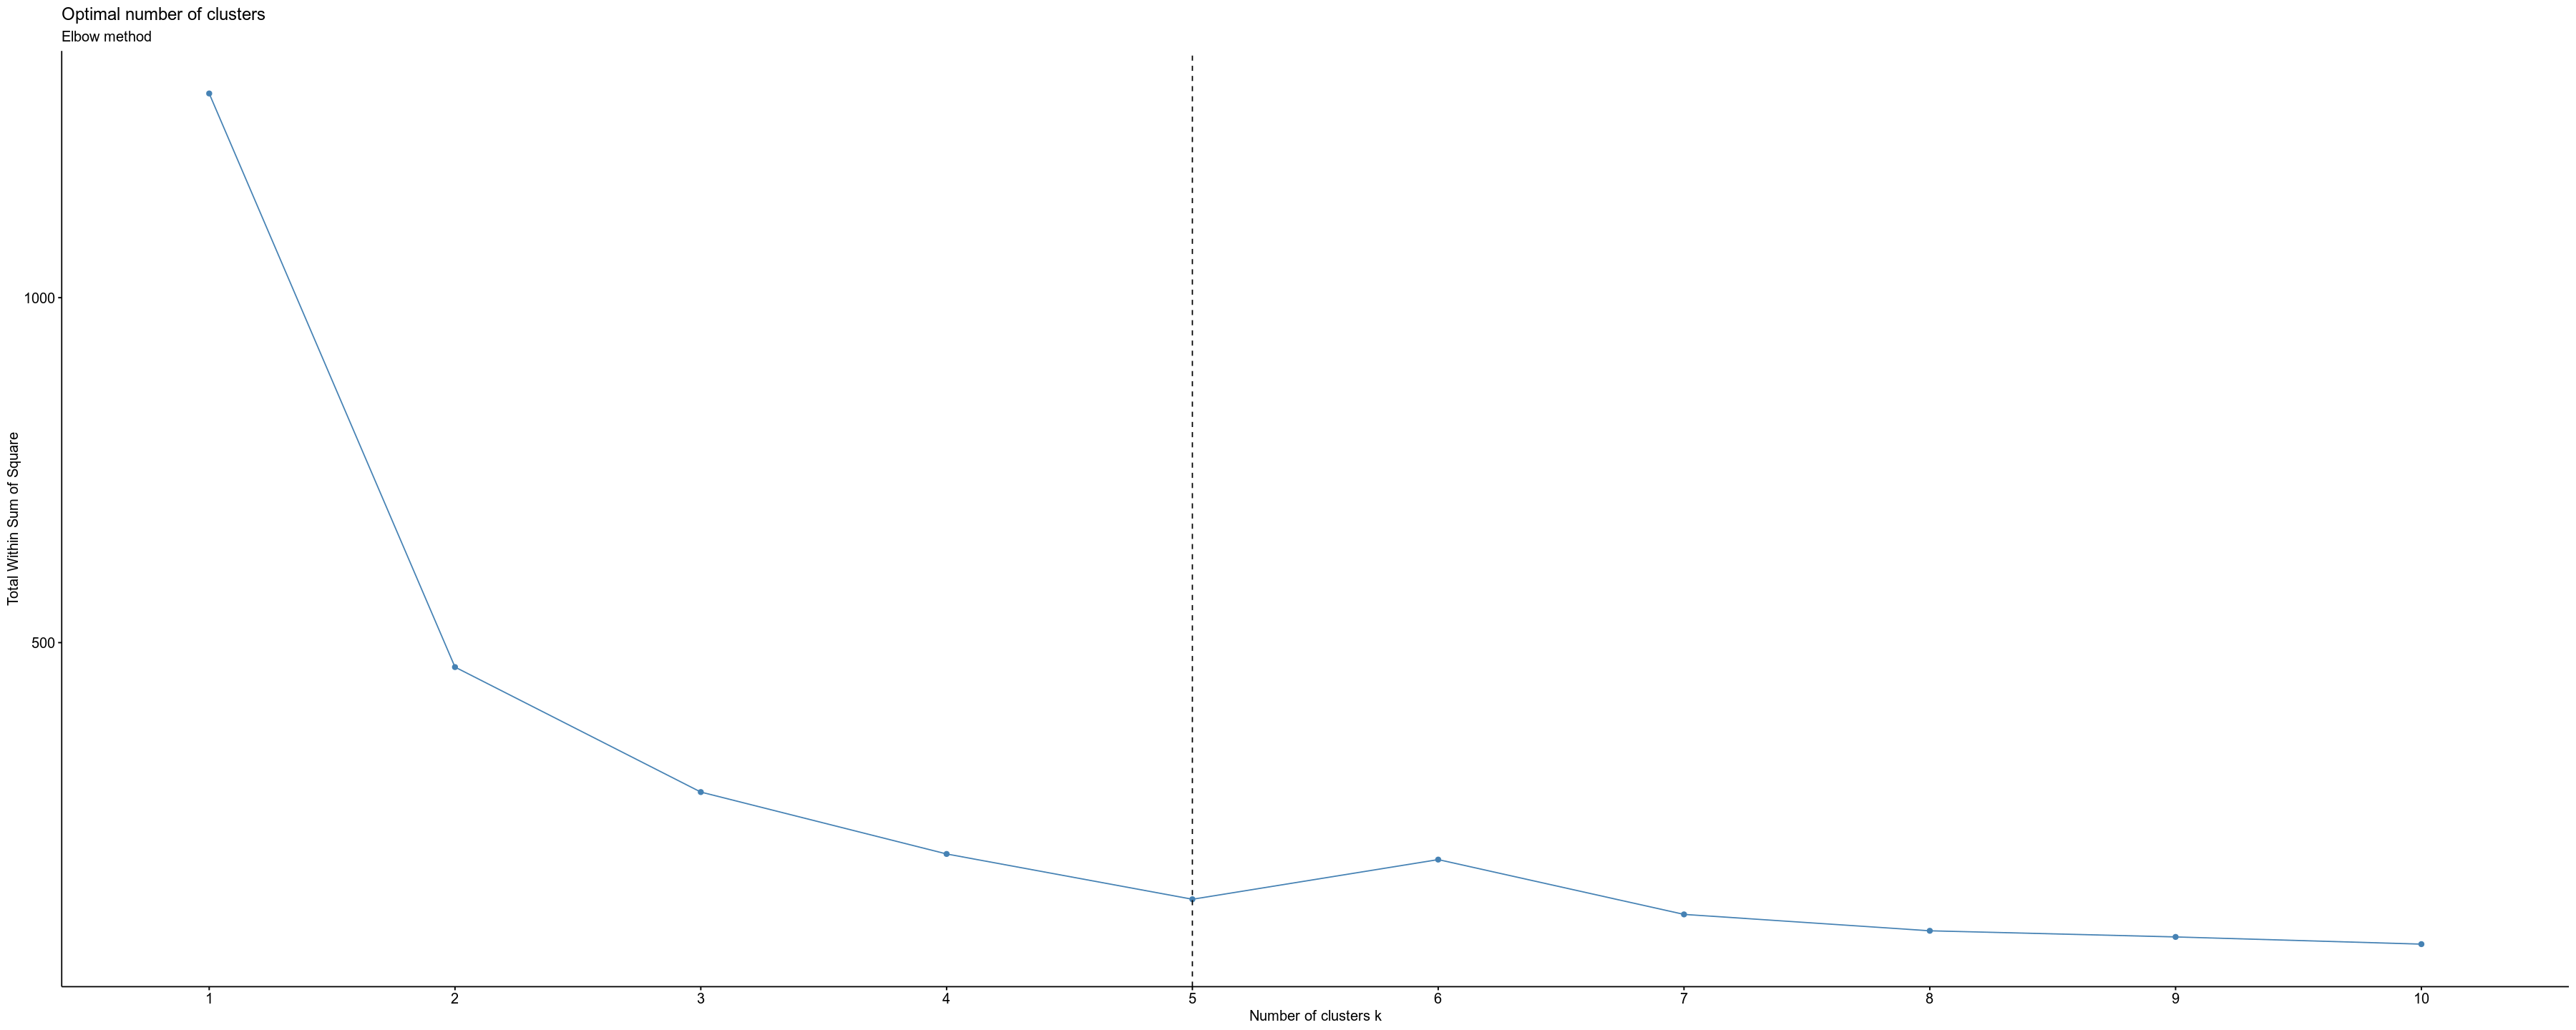

In [80]:
# Elbow method
fviz_nbclust(data_chr_transpose_scaled, kmeans, method = "wss") +
    geom_vline(xintercept = 5, linetype = 2)+
  labs(subtitle = "Elbow method")

Silhouette method

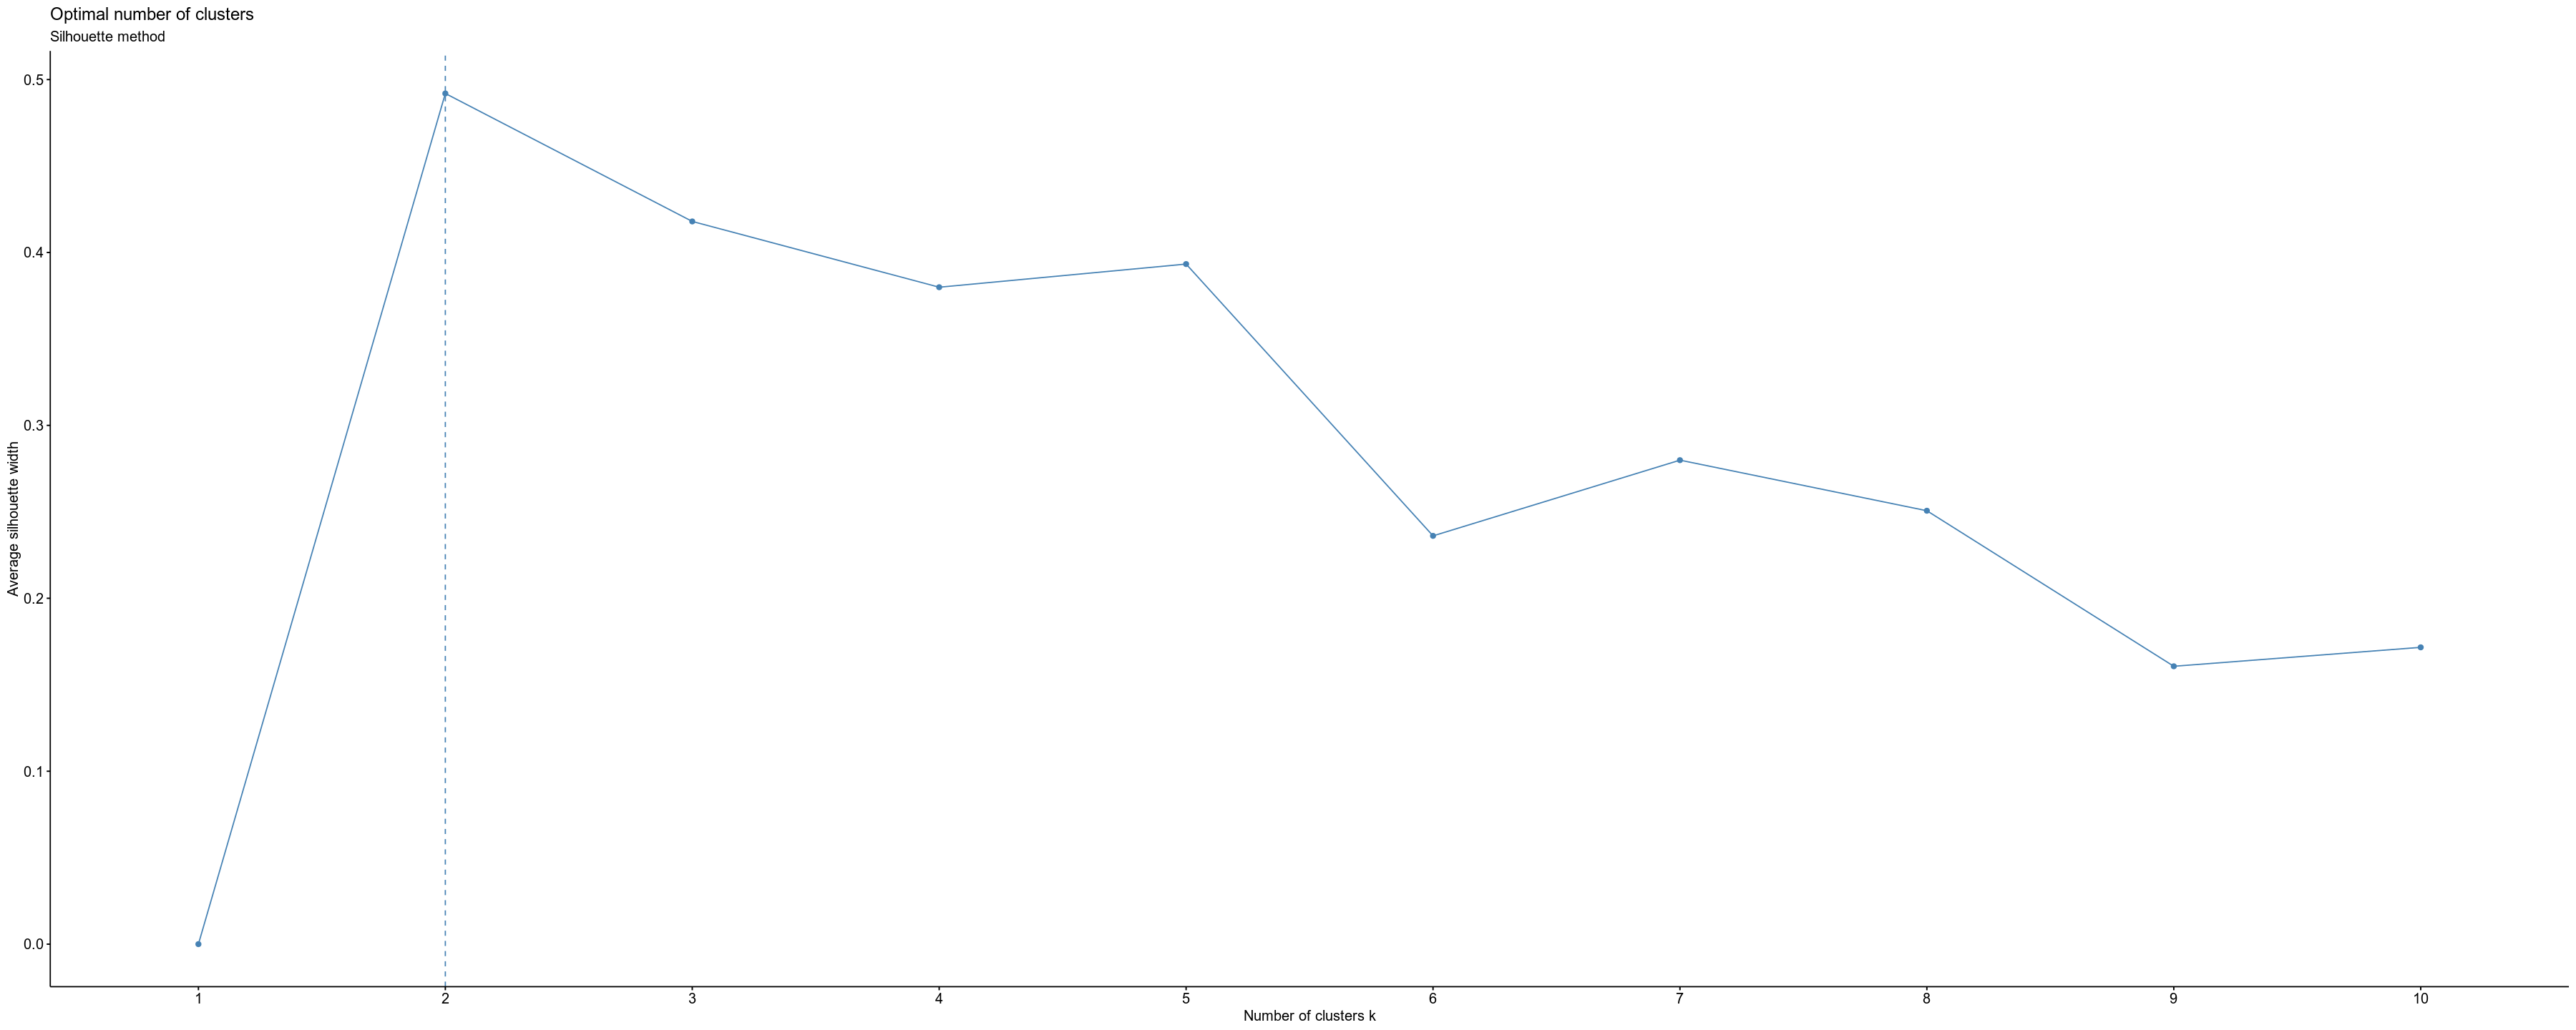

In [81]:
# Silhouette method
fviz_nbclust(data_chr_transpose_scaled, kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")

Gap statistic

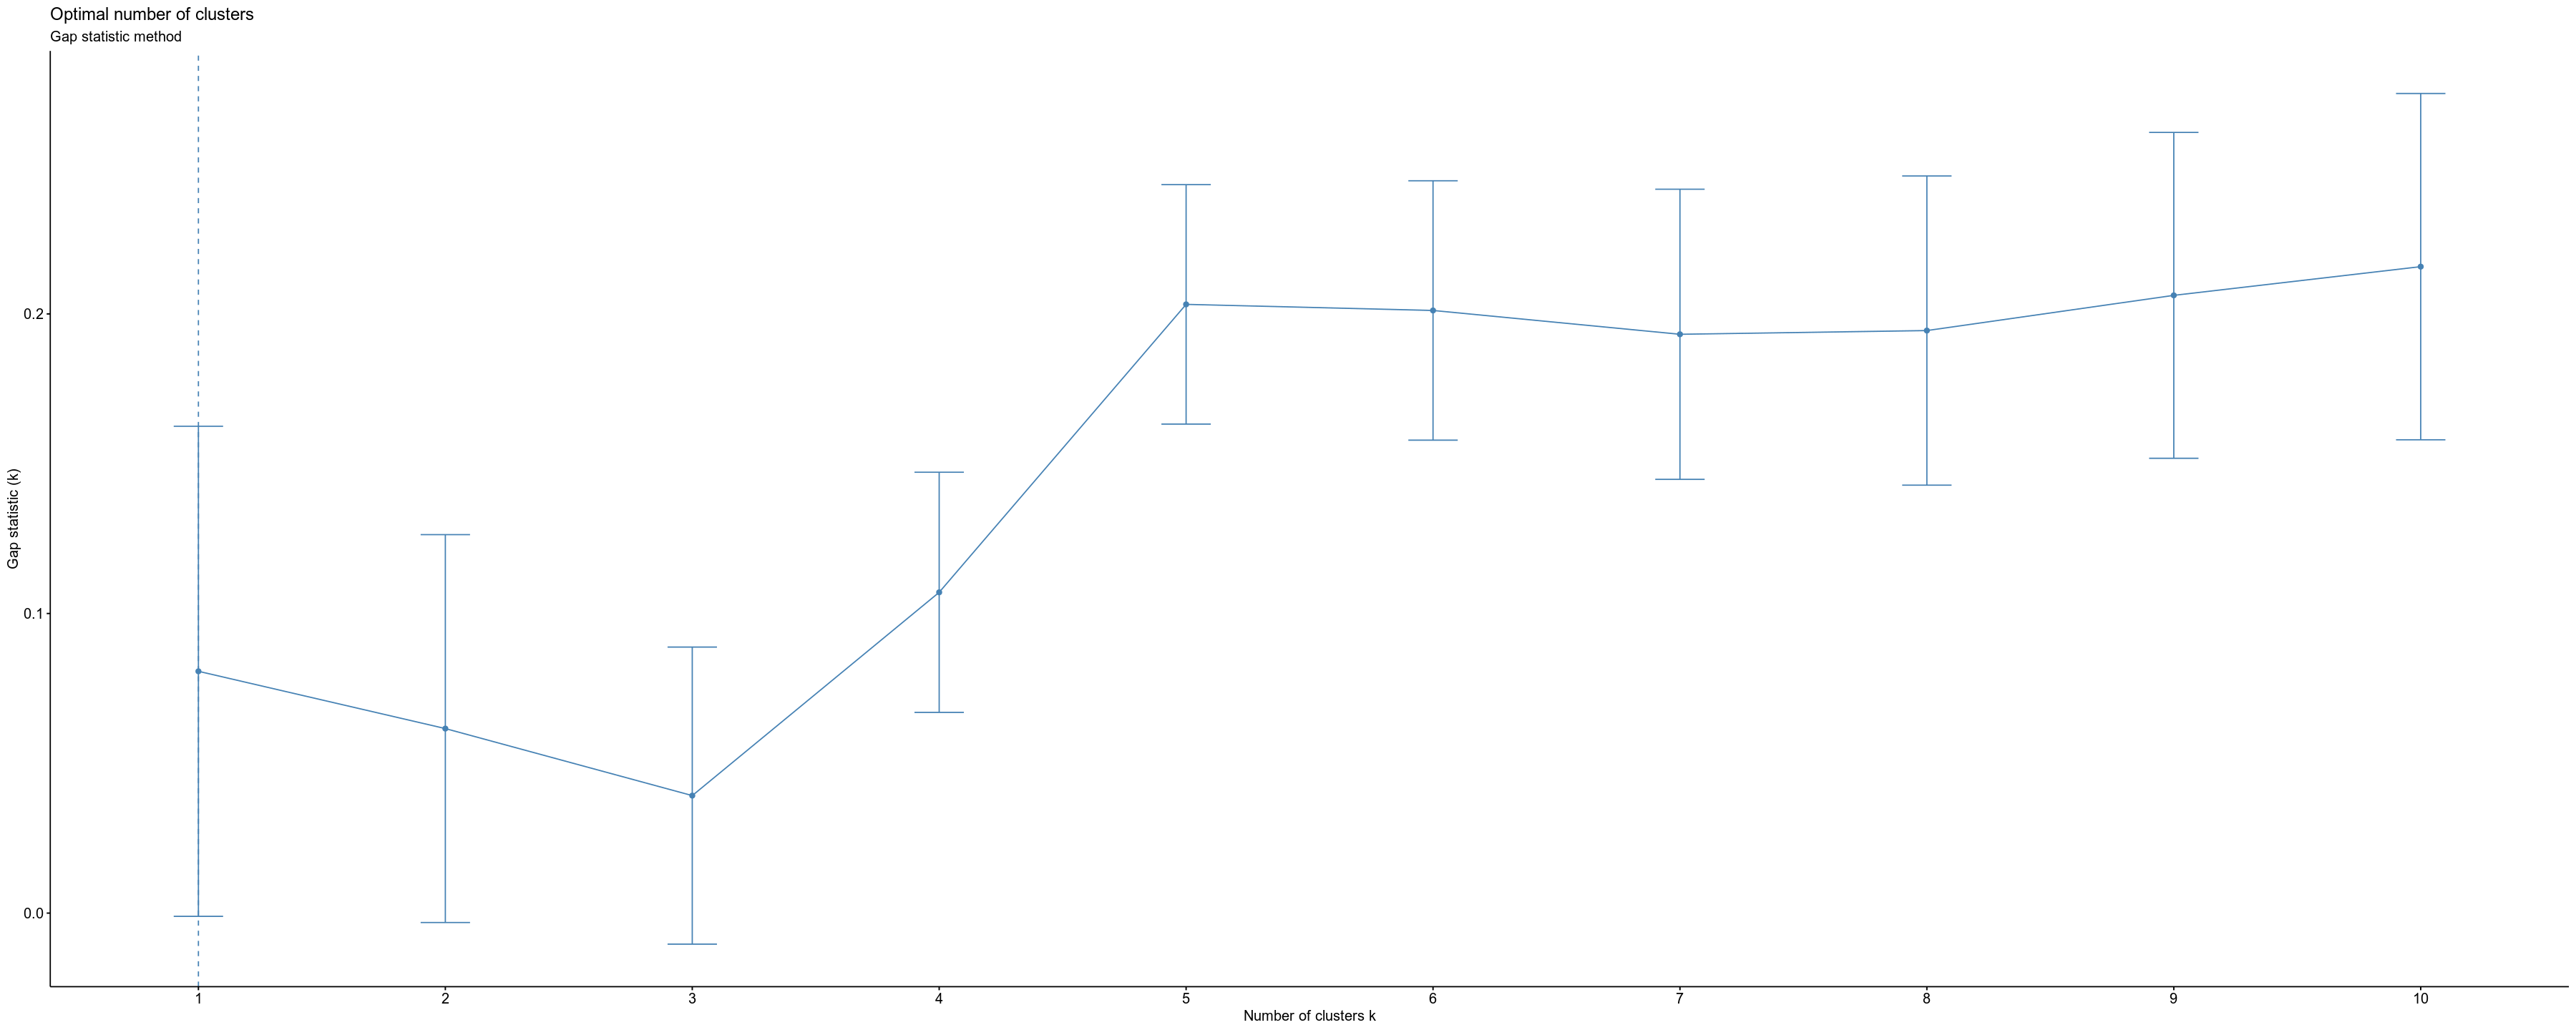

In [82]:
# Gap statistic
# nboot = 50 to keep the function speedy. 
# recommended value: nboot= 500 for your analysis.
# Use verbose = FALSE to hide computing progression.
set.seed(123)
fviz_nbclust(data_chr_transpose_scaled, kmeans, nstart = 25,  method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method")

##### Heatmap
A heatmap will aso provide a visual indicator of how chromosomes are grouped, and show a preeliminary hierarchical clustering diagram.

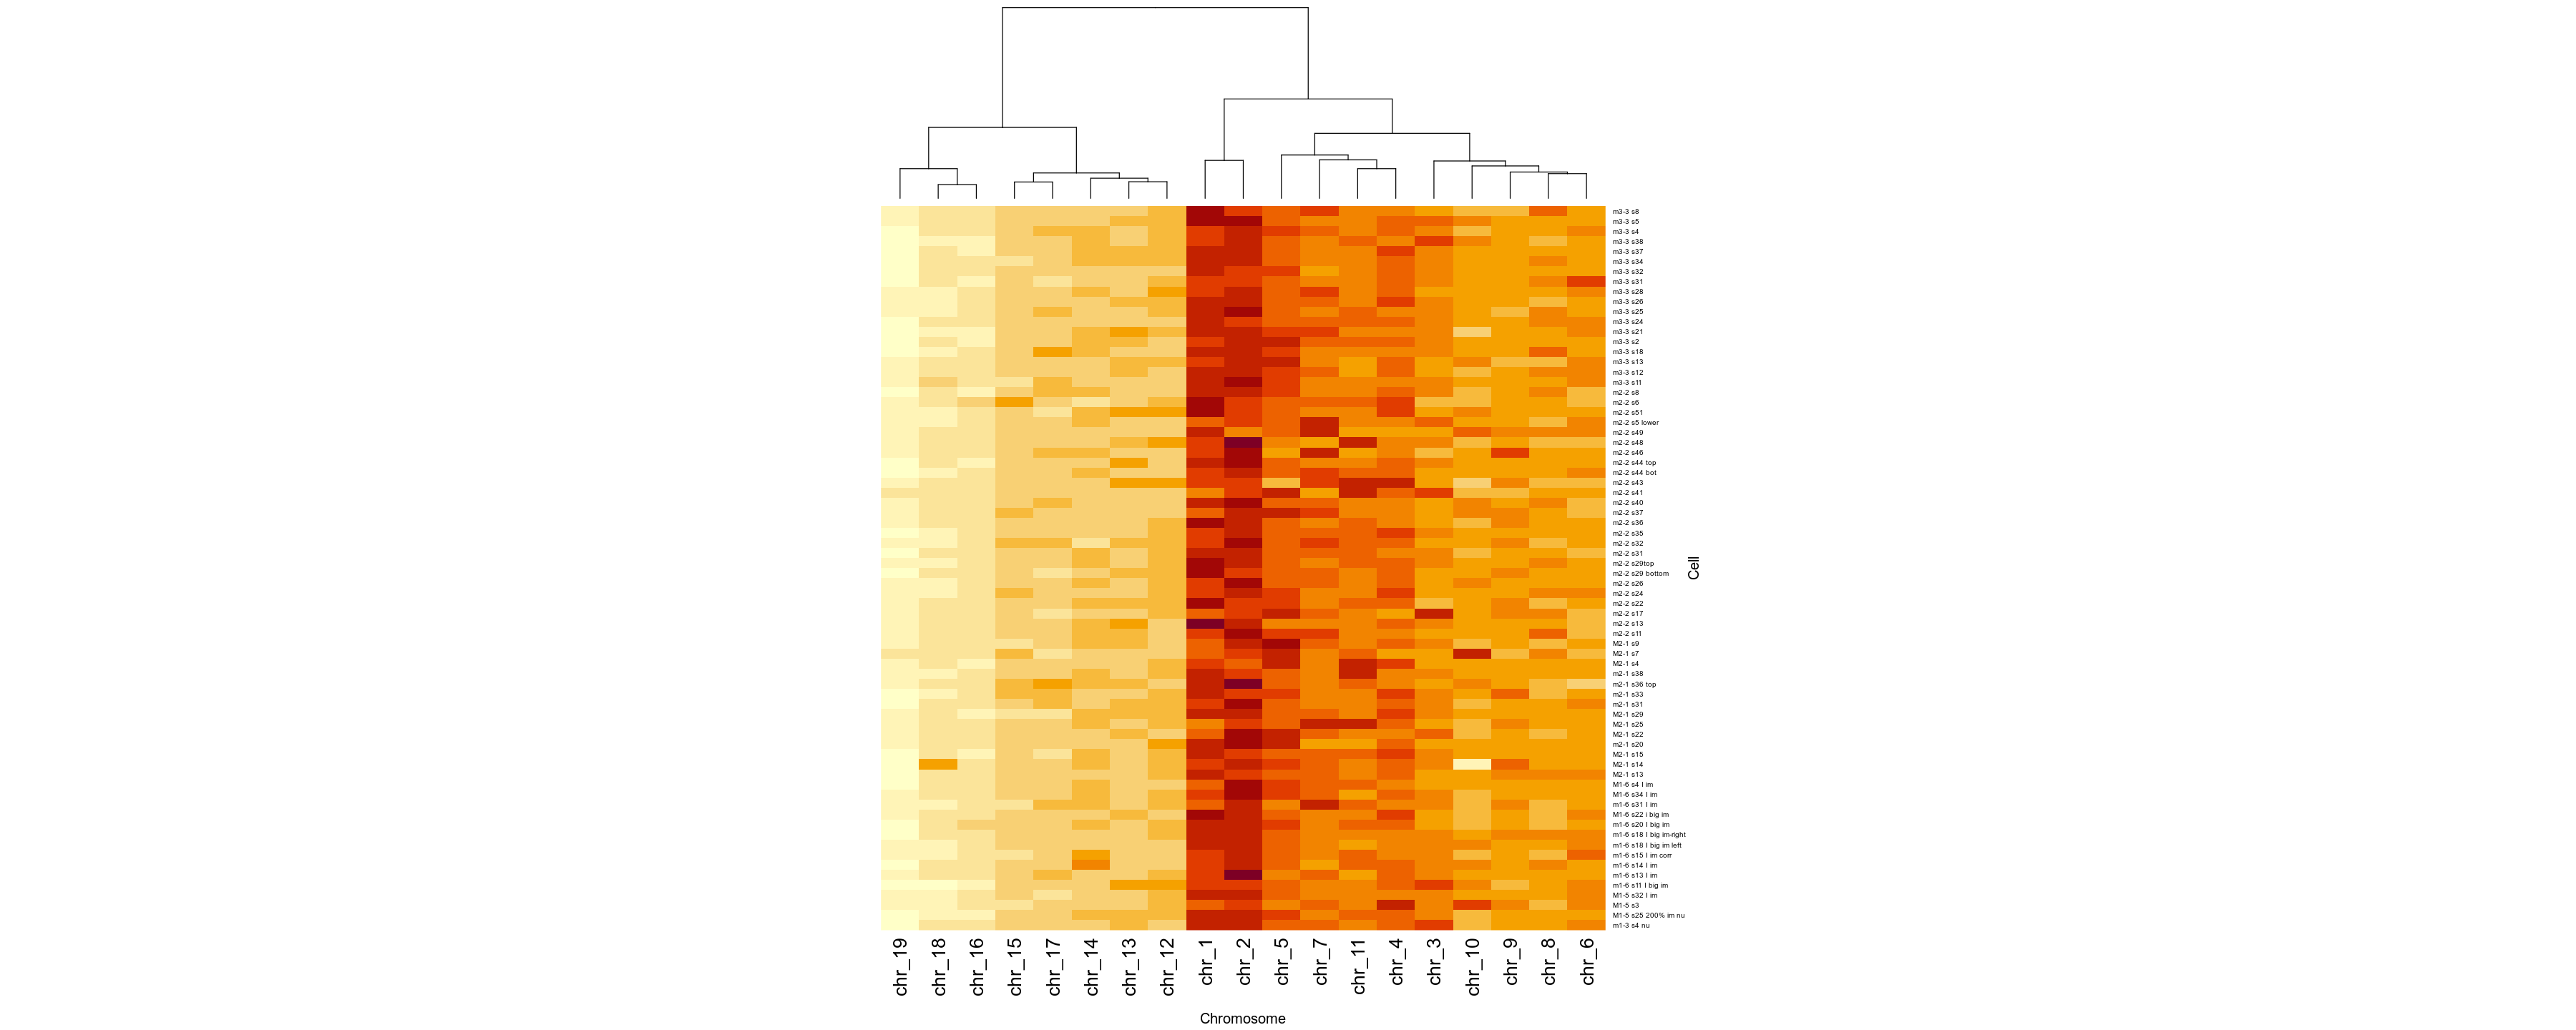

In [127]:
heatmap(as.matrix(data_chr), Rowv = NA, cexRow = 0.6, cexCol = 1.6, margins = c(7, 7), xlab = "Chromosome", ylab = "Cell")
#heatmap(as.matrix(corr), Colv = NA, Rowv = NA)

##### Correlation table

In [ ]:
#install.packages("Hmisc") # necessary for rcorr
#rcorr(x, type = c("pearson","spearman"))

corr <- cor(data_chr, method = c("pearson", "kendall", "spearman"))
corr

,chr_1,chr_2,chr_3,chr_4,chr_5,chr_6,chr_7,chr_8,chr_9,chr_10,chr_11,chr_12,chr_13,chr_14,chr_15,chr_16,chr_17,chr_18,chr_19
chr_1,1.0000000000,0.01220937,-0.419533821,0.08906325,-0.19613696,-0.1288464110,-0.01725590,0.188010977,0.03021400,-0.0006964467,-0.15642468,-0.111354440,0.005118003,-0.23630617,-0.01604349,-0.09520897,-0.0027702368,-0.13132133,-0.23361181
chr_2,0.0122093679,1.00000000,-0.111492686,-0.11550918,0.05165968,-0.2931327351,0.03618320,-0.134567097,0.07173201,-0.0962245496,0.01980853,-0.270323865,-0.211062386,-0.20348309,-0.26329084,-0.12409252,0.1645555667,-0.21518583,-0.22501298
chr_3,-0.4195338212,-0.11149269,1.000000000,-0.19950674,0.13959543,0.1549093434,-0.26717372,-0.176246270,-0.29899983,-0.0565477337,0.11607465,0.004977617,0.048942830,0.07542142,-0.09121401,0.04844018,0.0013913561,0.08118358,0.13081545
chr_4,0.0890632454,-0.11550918,-0.199506743,1.00000000,-0.10700662,-0.1385782045,-0.14275177,-0.266021890,-0.01005924,-0.2041425863,0.23581960,0.298756313,0.112486000,-0.20030786,0.01758115,-0.04274071,-0.0773874883,-0.13539113,-0.21980013
chr_5,-0.1961369560,0.05165968,0.139595429,-0.10700662,1.00000000,-0.0518721445,-0.17259455,0.065486605,-0.28641918,0.1968699724,-0.05621662,-0.238917382,-0.355881130,-0.17500329,0.04169036,-0.20850440,-0.2184484360,-0.08137847,0.03660537
chr_6,-0.1288464110,-0.29313274,0.154909343,-0.13857820,-0.05187214,1.0000000000,-0.02017553,-0.008548141,-0.04544858,-0.0528094633,-0.34689395,0.019792199,0.066052439,0.17215514,-0.07247208,-0.08219343,0.0003383122,0.14306079,0.19195473
chr_7,-0.0172558960,0.03618320,-0.267173720,-0.14275177,-0.17259455,-0.0201755292,1.00000000,0.210695227,0.56319158,-0.0216370860,-0.05779970,-0.347895691,-0.166299797,-0.17807422,-0.29217033,-0.28358630,-0.1307311745,-0.32402183,-0.34289045
chr_8,0.1880109770,-0.13456710,-0.176246270,-0.26602189,0.06548661,-0.0085481408,0.21069523,1.000000000,-0.04559987,0.1761394461,-0.23275938,-0.238880808,-0.277172700,-0.03935011,-0.06858157,-0.08980276,-0.1126435643,-0.08614174,-0.06956003
chr_9,0.0302139952,0.07173201,-0.298999831,-0.01005924,-0.28641918,-0.0454485841,0.56319158,-0.045599869,1.00000000,-0.1210697669,-0.05053311,-0.226737143,-0.191174646,-0.05180035,-0.27419283,-0.11970088,-0.0609950108,-0.05457494,-0.36330671
chr_10,-0.0006964467,-0.09622455,-0.056547734,-0.20414259,0.19686997,-0.0528094633,-0.02163709,0.176139446,-0.12106977,1.0000000000,-0.15586680,-0.190685427,-0.218705560,-0.07118243,0.03720170,-0.11713374,-0.2992019315,-0.33881443,0.05003603


### K-means based on 5 clusters <a class="anchor" id="k-means-clustering"></a>
Once determined the appropiate number of clusters, we proceed with the unsupervised clustering process using K=5.

In [129]:
nclusters <- 5

set.seed(20)
chrLenCluster <- kmeans(data_chr_transpose, nclusters, nstart = 20)
chrLenCluster

#length(chrLenCluster$cluster)
#rownames(data_chr_transpose)
table(chrLenCluster$cluster, rownames(data_chr_transpose))

K-means clustering with 5 clusters of sizes 5, 5, 4, 2, 3

Cluster means:
  m1-3 s4 nu M1-5 s25 200% im nu    M1-5 s3 M1-5 s32 I im m1-6 s11 I big im
1 0.04547735          0.04536547 0.04249210    0.04535485        0.04821014
2 0.05524851          0.05403135 0.05827281    0.05609438        0.05664311
3 0.06150557          0.06439463 0.06533014    0.05998766        0.06064534
4 0.07257118          0.07356879 0.06897125    0.07281874        0.06740165
5 0.03506868          0.03276660 0.03230414    0.03572192        0.03278302
  m1-6 s13 I im m1-6 s14 I im m1-6 s15 I im corr m1-6 s18 I big im left
1    0.04443970    0.04578201         0.04542340             0.04485848
2    0.05367104    0.05650819         0.05511655             0.05722327
3    0.06126934    0.06088243         0.06352480             0.05945175
4    0.08016881    0.07106625         0.07310013             0.07353759
5    0.03467711    0.03429560         0.03233360             0.03490301
  m1-6 s18 I big im-right m1-6 s20 I b

   
    chr_1 chr_10 chr_11 chr_12 chr_13 chr_14 chr_15 chr_16 chr_17 chr_18 chr_19
  1     0      0      0      1      1      1      1      0      1      0      0
  2     0      1      0      0      0      0      0      0      0      0      0
  3     0      0      1      0      0      0      0      0      0      0      0
  4     1      0      0      0      0      0      0      0      0      0      0
  5     0      0      0      0      0      0      0      1      0      1      1
   
    chr_2 chr_3 chr_4 chr_5 chr_6 chr_7 chr_8 chr_9
  1     0     0     0     0     0     0     0     0
  2     0     1     0     0     1     0     1     1
  3     0     0     1     1     0     1     0     0
  4     1     0     0     0     0     0     0     0
  5     0     0     0     0     0     0     0     0

### Chromosome grouping <a class="anchor" id="chromosome-grouping"></a>

In the table above, we can see where the algorithm has placed each one of the chromosomes, considering there are 5 clusters.

Based on this, if we cluster the data in 5 groups, the chromosomes would be grouped the following way:

| Group   | Chromosomes        |
|---------|--------------------|
| Group 1 | 1, 2               |
| Group 2 | 5, 7, 11, 4        |
| Group 3 | 3, 10, 9, 8, 6     |
| Group 4 | 15, 17, 14, 13, 12 |
| Group 5 | 19, 18, 16         |


However, under normal circumstances, we won't have the real chromosome number available, just the chromosome length, so the most we can do is rank their length, and hope that corresponds to the real chromosome number. 
For that purpose, we'll do a second grouping using correlative chromosome lengths, with the same amount of chromosomes per group, that we'll use to compare it against and check how well it matches:

| Group   | Chromosomes        |
|---------|--------------------|
| Group 1 | 1, 2               |
| Group 2 | 3, 4, 5, 6         |
| Group 3 | 7, 8, 9, 10, 11    |
| Group 4 | 12, 13, 14, 15, 16 |
| Group 5 | 17, 18, 19         |

We will save these two groupings in two new lists of lists: `chr_groups` for non consecutive chromosomes (the clustering obtained through K-means) and `rnk_groups` for grouping of consecutive chromosomes based on chromosome length. 

The original data will be imported again to clear all the previous extra columns and calculations.

In [154]:
# Let's start with the original dataset again
data <- read.csv("mouse data Froenicke et al 2002.csv", sep = ";")
data <- data[, 1:7]
head(data)

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18


In [155]:
chr_group1 <- c(1, 2)
chr_group2 <- c(5, 7, 11, 4)
chr_group3 <- c(3, 10, 9, 8, 6)
chr_group4 <- c(15, 17, 14, 13, 12)
chr_group5 <- c(19, 18, 16)
chr_groups <- list(chr_group1, chr_group2, chr_group3, chr_group4, chr_group5)

chr_groups

rnk_group1 <- c(1:2)
rnk_group2 <- c(3:6)
rnk_group3 <- c(7:11)
rnk_group4 <- c(12:16)
rnk_group5 <- c(17:19)
rnk_groups <- list(rnk_group1, rnk_group2, rnk_group3, rnk_group4, rnk_group5)

rnk_groups

[[1]]
[1] 1 2

[[2]]
[1]  5  7 11  4

[[3]]
[1]  3 10  9  8  6

[[4]]
[1] 15 17 14 13 12

[[5]]
[1] 19 18 16

[[1]]
[1] 1 2

[[2]]
[1] 3 4 5 6

[[3]]
[1]  7  8  9 10 11

[[4]]
[1] 12 13 14 15 16

[[5]]
[1] 17 18 19

#### Compare the chromosome groups and rank groups
We add the necessary columns in the dataframe to store in which `chr_group` and `rnk_group` the chromosome `FITC.Rank` corresponds, and a third one `group_match` to store the boolean value if they match.

In [156]:
# add columns to the main dataframe to store the comparisons
data$chr_group <- NA
data$rnk_group <- NA
data$group_match <- NA
head(data)

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,chr_group,rnk_group,group_match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,NA,NA,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,NA,NA,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,NA,NA,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,NA,NA,NA
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,NA,NA,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,NA,NA,NA


Check to which chromosome group corresponds each chromosome number (`FITC.Rank`).

In [157]:
results <- vector() #new empty vector

for (i in 1:nrow(data)) {
    #cat("\nRow", i, "Comparing chromosome ", data[[i, "FITC.Rank"]], "of cell", data[[i, "Set.ID"]])
    for (group in 1:length(chr_groups)){ # groups 1 to 5
        #cat("\n Group", group, "that contains the chromosomes:", chr_groups[[group]])
        stop <- FALSE
        for (element in 1:length(chr_groups[[group]])){ # for each chromosome in group

            if (data[[i,"FITC.Rank"]] == chr_groups[[group]][element]){
                #cat("\n    Sí és el element", element,"del grup", group)
                results <- c(results, group)
                stop <- TRUE
                break
            }  
        }
        if (stop == TRUE ){ break } # Break the outer loop when the flag is fired 
    }
}
nrow(data)
length(results) # they must match in size. Otherwise something is wrong.
#head(results)
data$chr_group <- results
head(data)

[1] 1368

[1] 1368

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,chr_group,rnk_group,group_match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,1,NA,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,1,NA,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,3,NA,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,2,NA,NA
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,2,NA,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,3,NA,NA


Before we continue, let's see how a boxplot of the chromosome relative length, colored by cluster looks.

Boxplot, Relative chromosome length `Rel.Len` by number of chromosome (`FITC.Rank`), hue by chromosome cluster:

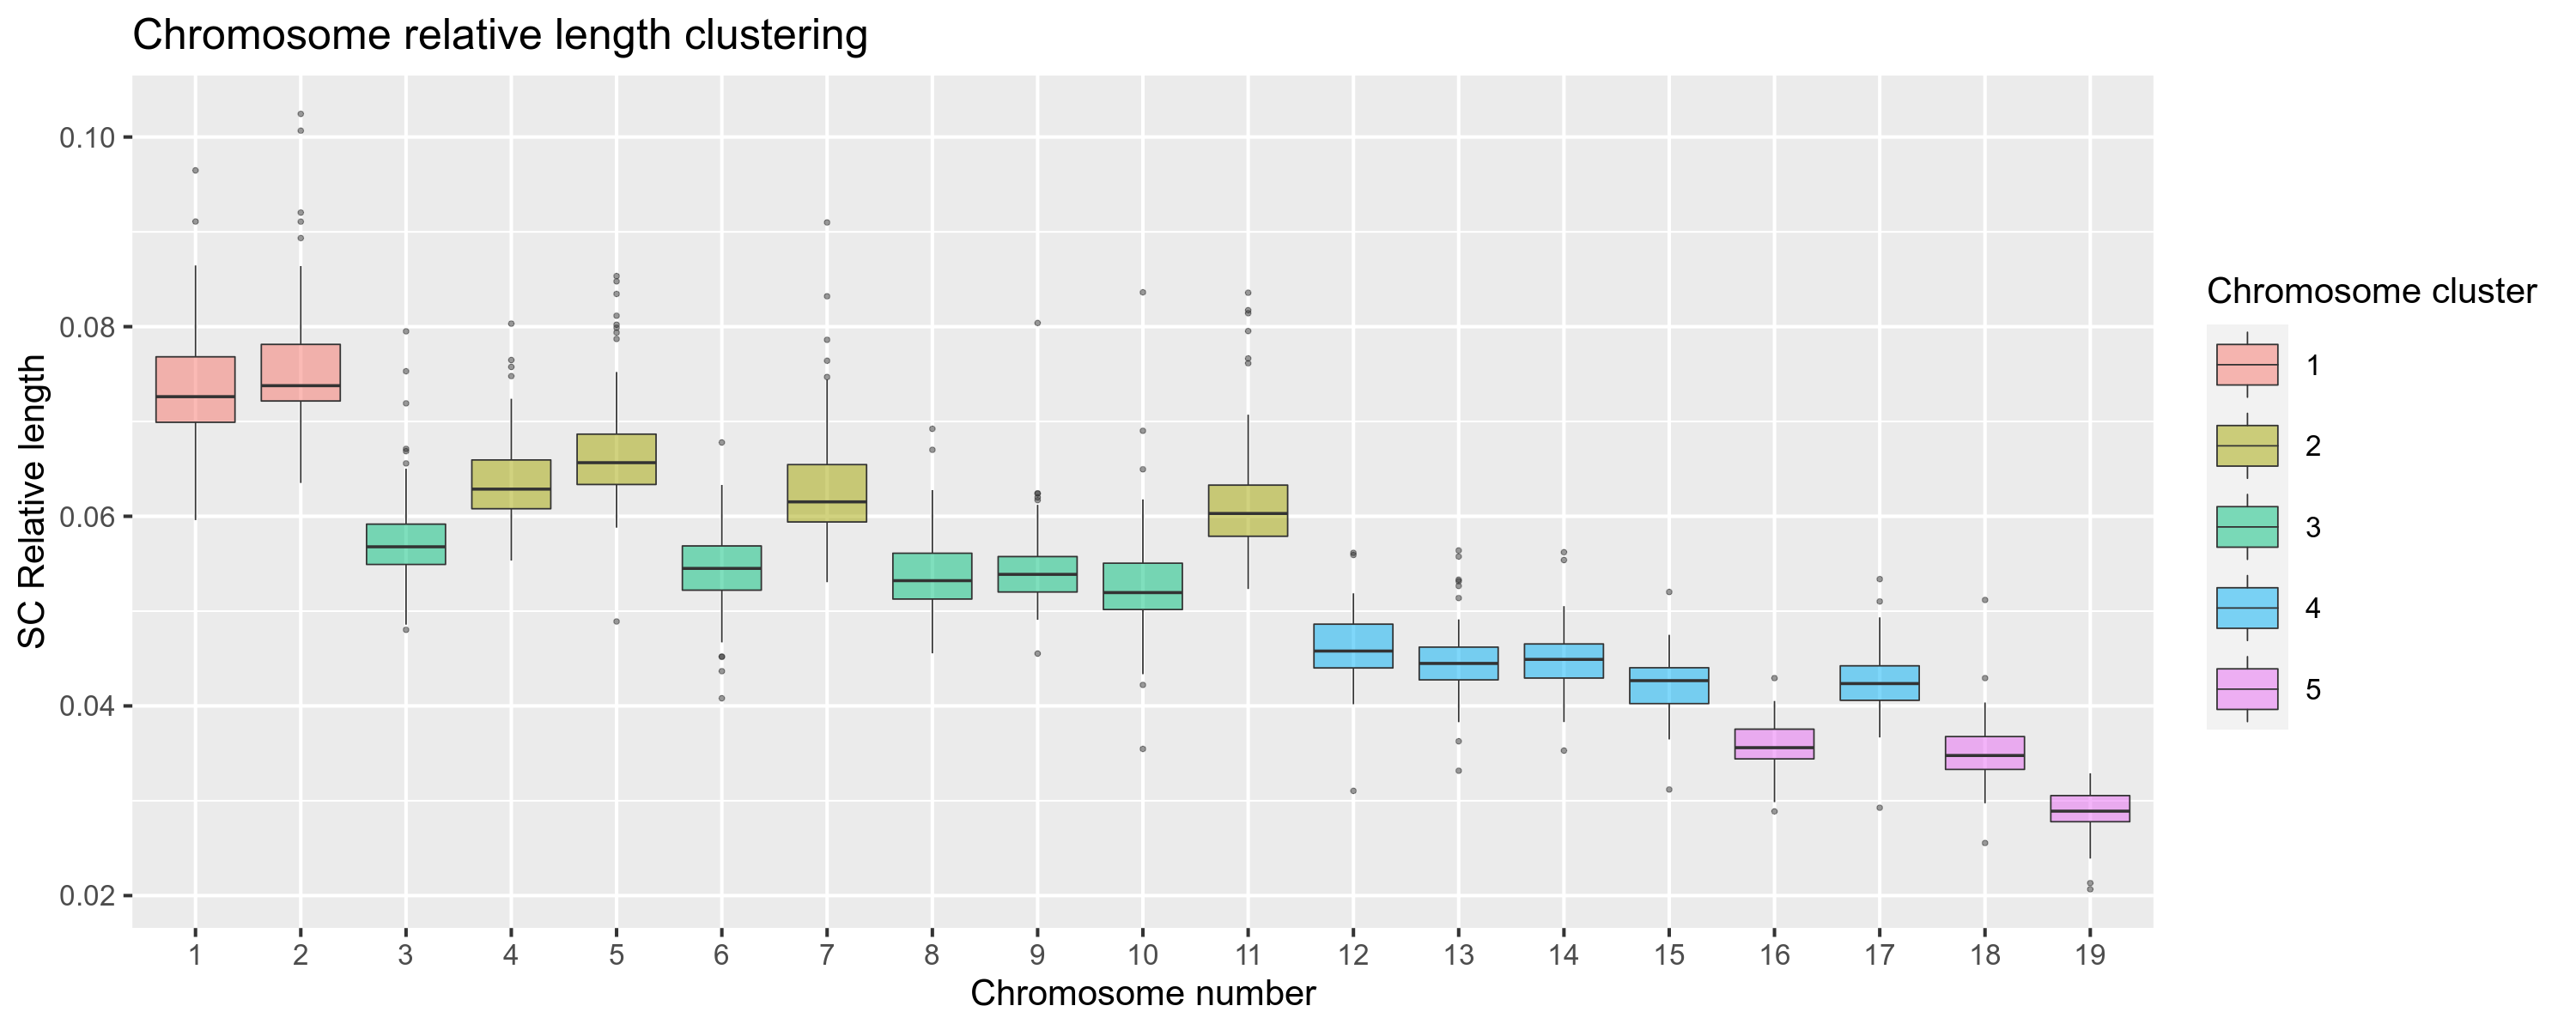

In [193]:
options(repr.plot.width=25, repr.plot.height=10) # Plot size
theme_set(theme_gray(base_size = 25))

ggplot(data, aes(x=as.factor(FITC.Rank), y=Rel.len, group=FITC.Rank, fill=as.factor(chr_group))) +
    geom_boxplot(alpha=0.5) + # type boxplot
    ggtitle("Chromosome relative length clustering") +
    xlab("Chromosome number") + # X axis label
    ylab("SC Relative length") + # Y axis label
    scale_fill_discrete(name = "Chromosome cluster") + # Legend title
    theme(legend.key.size = unit(2, 'cm'))  # Legend key size

And now we fill the `rnk_group` column with the group that corresponds to that particular chromosome length rank (`Lgth.Rank`).

In [158]:
# Check to which rank group corresponds each Lgth.Rank

results <- vector() #new empty vector


for (i in 1:nrow(data)) {
    #cat("\nRow", i, "Comparing chromosome ", data[[i, "FITC.Rank"]], "of cell", data[[i, "Set.ID"]])
    for (group in 1:length(rnk_groups)){ # groups 1 to 5
        stop <- FALSE
        for (element in 1:length(rnk_groups[[group]])){ # for each chromosome in group
            #cat("\n  Chromosome:", element)
            if (data[[i,"Lgth.Rank"]] == rnk_groups[[group]][element]){
                results <- c(results, group)
                stop <- TRUE
                break
            }
        }
        if (stop == TRUE ){ break } # Break the outer loop when the flag is fired 
    }
}
nrow(data)
length(results) # they must match in size. Otherwise something is wrong.
#head(results)
data$rnk_group <- results
head(data)

[1] 1368

[1] 1368

,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,chr_group,rnk_group,group_match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,1,1,NA
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,1,1,NA
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,3,2,NA
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,2,2,NA
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,2,2,NA
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,3,3,NA


And now we check whether the two columns (`rnk_group` and `chr_group`) match and store the boolean value in `group_match`:

In [159]:
results <- vector()
for(i in 1:nrow(data)) {       # for-loop over rows
    #print(data[[i,"FITC.Rank"]])
    if (data[[i,"chr_group"]] == data[[i,"rnk_group"]]){
        #print("Son lo mateix.")
        results <- c(results, TRUE)
    }
    else {
        #print("No coincideixen")
        results <- c(results, FALSE)
    }
}
print(head(results))


data$group_match <- results # insert the values of vector "results" to the Rank.Match column in the data dataframe
head(data)
#write.csv(data,"rankmatches.csv", row.names = FALSE)


[1]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE


,mouse,Set.ID,FITC.Rank,Lgth.Rank,Rel.len,Total.Len,Len,chr_group,rnk_group,group_match
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>
1,1,m1-3 s4 nu,1,2,0.07181488,179.06,12.86,1,1,TRUE
2,1,m1-3 s4 nu,2,1,0.07332749,179.06,13.13,1,1,TRUE
3,1,m1-3 s4 nu,3,3,0.06686973,179.06,11.97,3,2,FALSE
4,1,m1-3 s4 nu,4,6,0.06120195,179.06,10.96,2,2,TRUE
5,1,m1-3 s4 nu,5,5,0.06388799,179.06,11.44,2,2,TRUE
6,1,m1-3 s4 nu,6,7,0.05684487,179.06,10.18,3,3,TRUE


#### Results <a class="anchor" id="grouping-results-plots"></a>

Global % of matching clusters

In [160]:
library(dplyr)

globalpercent = sum((data[["group_match"]]) == TRUE)/count(data)*100
globalpercent = globalpercent[[1]]
cat(globalpercent,"% of the chromosomes fit the predicted rank interval.")

84.64912 % of the chromosomes fit the predicted rank interval.

Matching (%) chromosome length cluster by cell (`Set.ID`)

In [205]:
# Grouped by cell
df_count_cell = count(data, Set.ID, group_match)


df_count_cell$Percent <- NA

percent = vector()
len = length(unique(data$FITC.Rank)) #  Number of distinc values in the column Set.ID
percent = c(percent, df_count_cell$n / len * 100)
df_count_cell$Percent <- percent

df_count_cell <- df_count_cell[!(df_count_cell$group_match == FALSE),] # drop cells with FALSE

summary(df_count_cell['Percent'])
df_count_cell[order(df_count_cell$Percent),]

write.csv(df_count_cell,"cellcount.csv", row.names = FALSE)

    Percent      
 Min.   : 47.37  
 1st Qu.: 78.95  
 Median : 89.47  
 Mean   : 84.65  
 3rd Qu.: 89.47  
 Max.   :100.00  

,Set.ID,group_match,n,Percent
,<chr>,<lgl>,<int>,<dbl>
82,m2-2 s43,TRUE,9,47.36842
53,M2-1 s7,TRUE,10,52.63158
35,m2-1 s20,TRUE,12,63.15789
37,M2-1 s22,TRUE,13,68.42105
76,m2-2 s37,TRUE,13,68.42105
80,m2-2 s41,TRUE,13,68.42105
89,m2-2 s48,TRUE,13,68.42105
91,m2-2 s49,TRUE,13,68.42105
95,m2-2 s51,TRUE,13,68.42105


We can observe that there are three outlier cells: *m2-2 s43*, *M2-1 s7* and *m2-1 s20*. If we exclude these three from the dataset, we can check if there's a big difference in the overall %.

After running the following calculation again, we increased the matching % from 84.64 to 85.96. Since it's not a great improvement, we'll keep these three variables in the dataset.

In [181]:
# Remove the 3 outlier cells
data_tmp <- data
data_tmp <- data_tmp[!(data$Set.ID == "m2-2 s43"), ]
data_tmp <- data_tmp[!(data_tmp$Set.ID == "M2-1 s7"), ]
data_tmp <- data_tmp[!(data_tmp$Set.ID == "m2-1 s20"), ]

globalpercent = sum((data_tmp[["group_match"]]) == TRUE)/count(data_tmp)*100
globalpercent = globalpercent[[1]]
cat(globalpercent,"% of the chromosomes fit the predicted rank interval.")

85.96491 % of the chromosomes fit the predicted rank interval.

Matching (%) chromosome length cluster by number of chromosome (`FITC.Rank`)

In [182]:
# Grouped by chromosome
df_count_chr = count(data, FITC.Rank, group_match)
#df_count_cell

df_count_chr$Percent <- NA

percent = vector()
len = length(unique(data$Set.ID)) #  Number of distinc values in the column Set.ID
percent = c(percent, df_count_chr$n / len * 100)
df_count_chr$Percent <- percent

df_count_chr <- df_count_chr[!(df_count_chr$group_match == FALSE),] # drop cells with FALSE

summary(df_count_chr['Percent'])
df_count_chr[order(df_count_chr$Percent),]
write.csv(df_count_chr,"chromosomecount.csv", row.names = FALSE)

    Percent      
 Min.   : 59.72  
 1st Qu.: 77.78  
 Median : 86.11  
 Mean   : 84.65  
 3rd Qu.: 95.14  
 Max.   :100.00  

,FITC.Rank,group_match,n,Percent
,<int>,<lgl>,<int>,<dbl>
22,11,TRUE,43,59.72222
14,7,TRUE,48,66.66667
2,1,TRUE,51,70.83333
6,3,TRUE,52,72.22222
12,6,TRUE,54,75.00000
10,5,TRUE,58,80.55556
8,4,TRUE,59,81.94444
20,10,TRUE,59,81.94444
4,2,TRUE,62,86.11111


##### Plots

Barplot, matching (%) chromosome length cluster by cell (`Set.ID`)

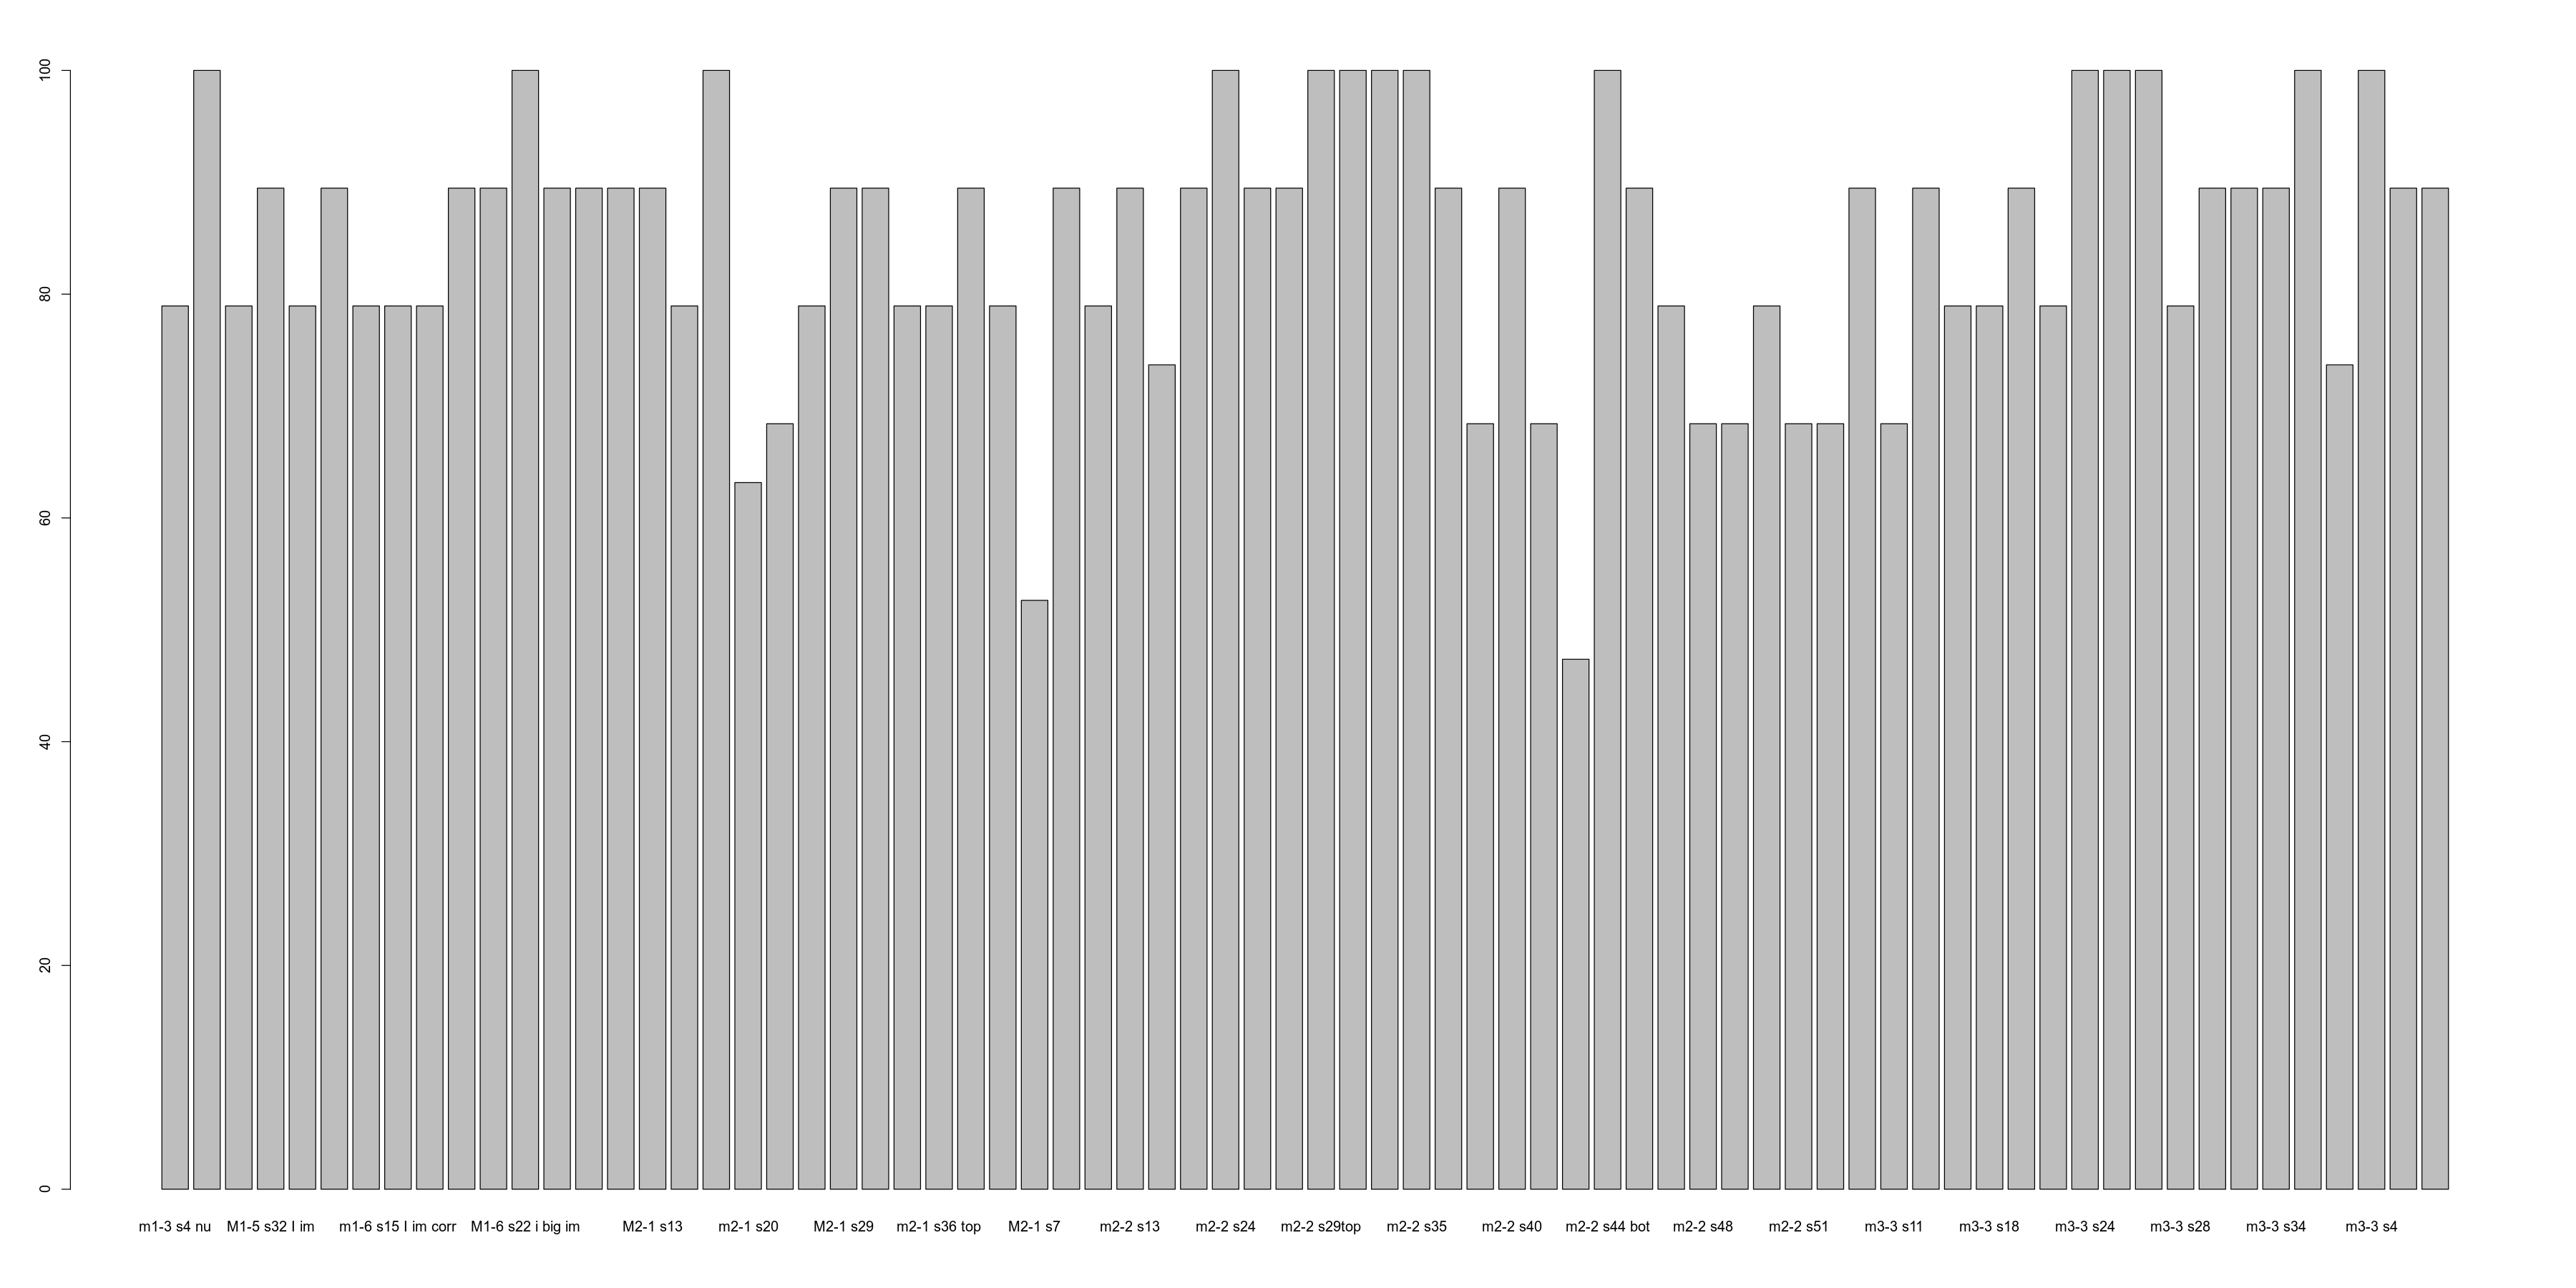

In [176]:
options(repr.plot.width=30, repr.plot.height=15) # Plot size

barplot(df_count_cell$Percent, names.arg=df_count_cell$Set.ID)

Barplot, matching (%) chromosome length cluster by number of chromosome (`FITC.Rank`)

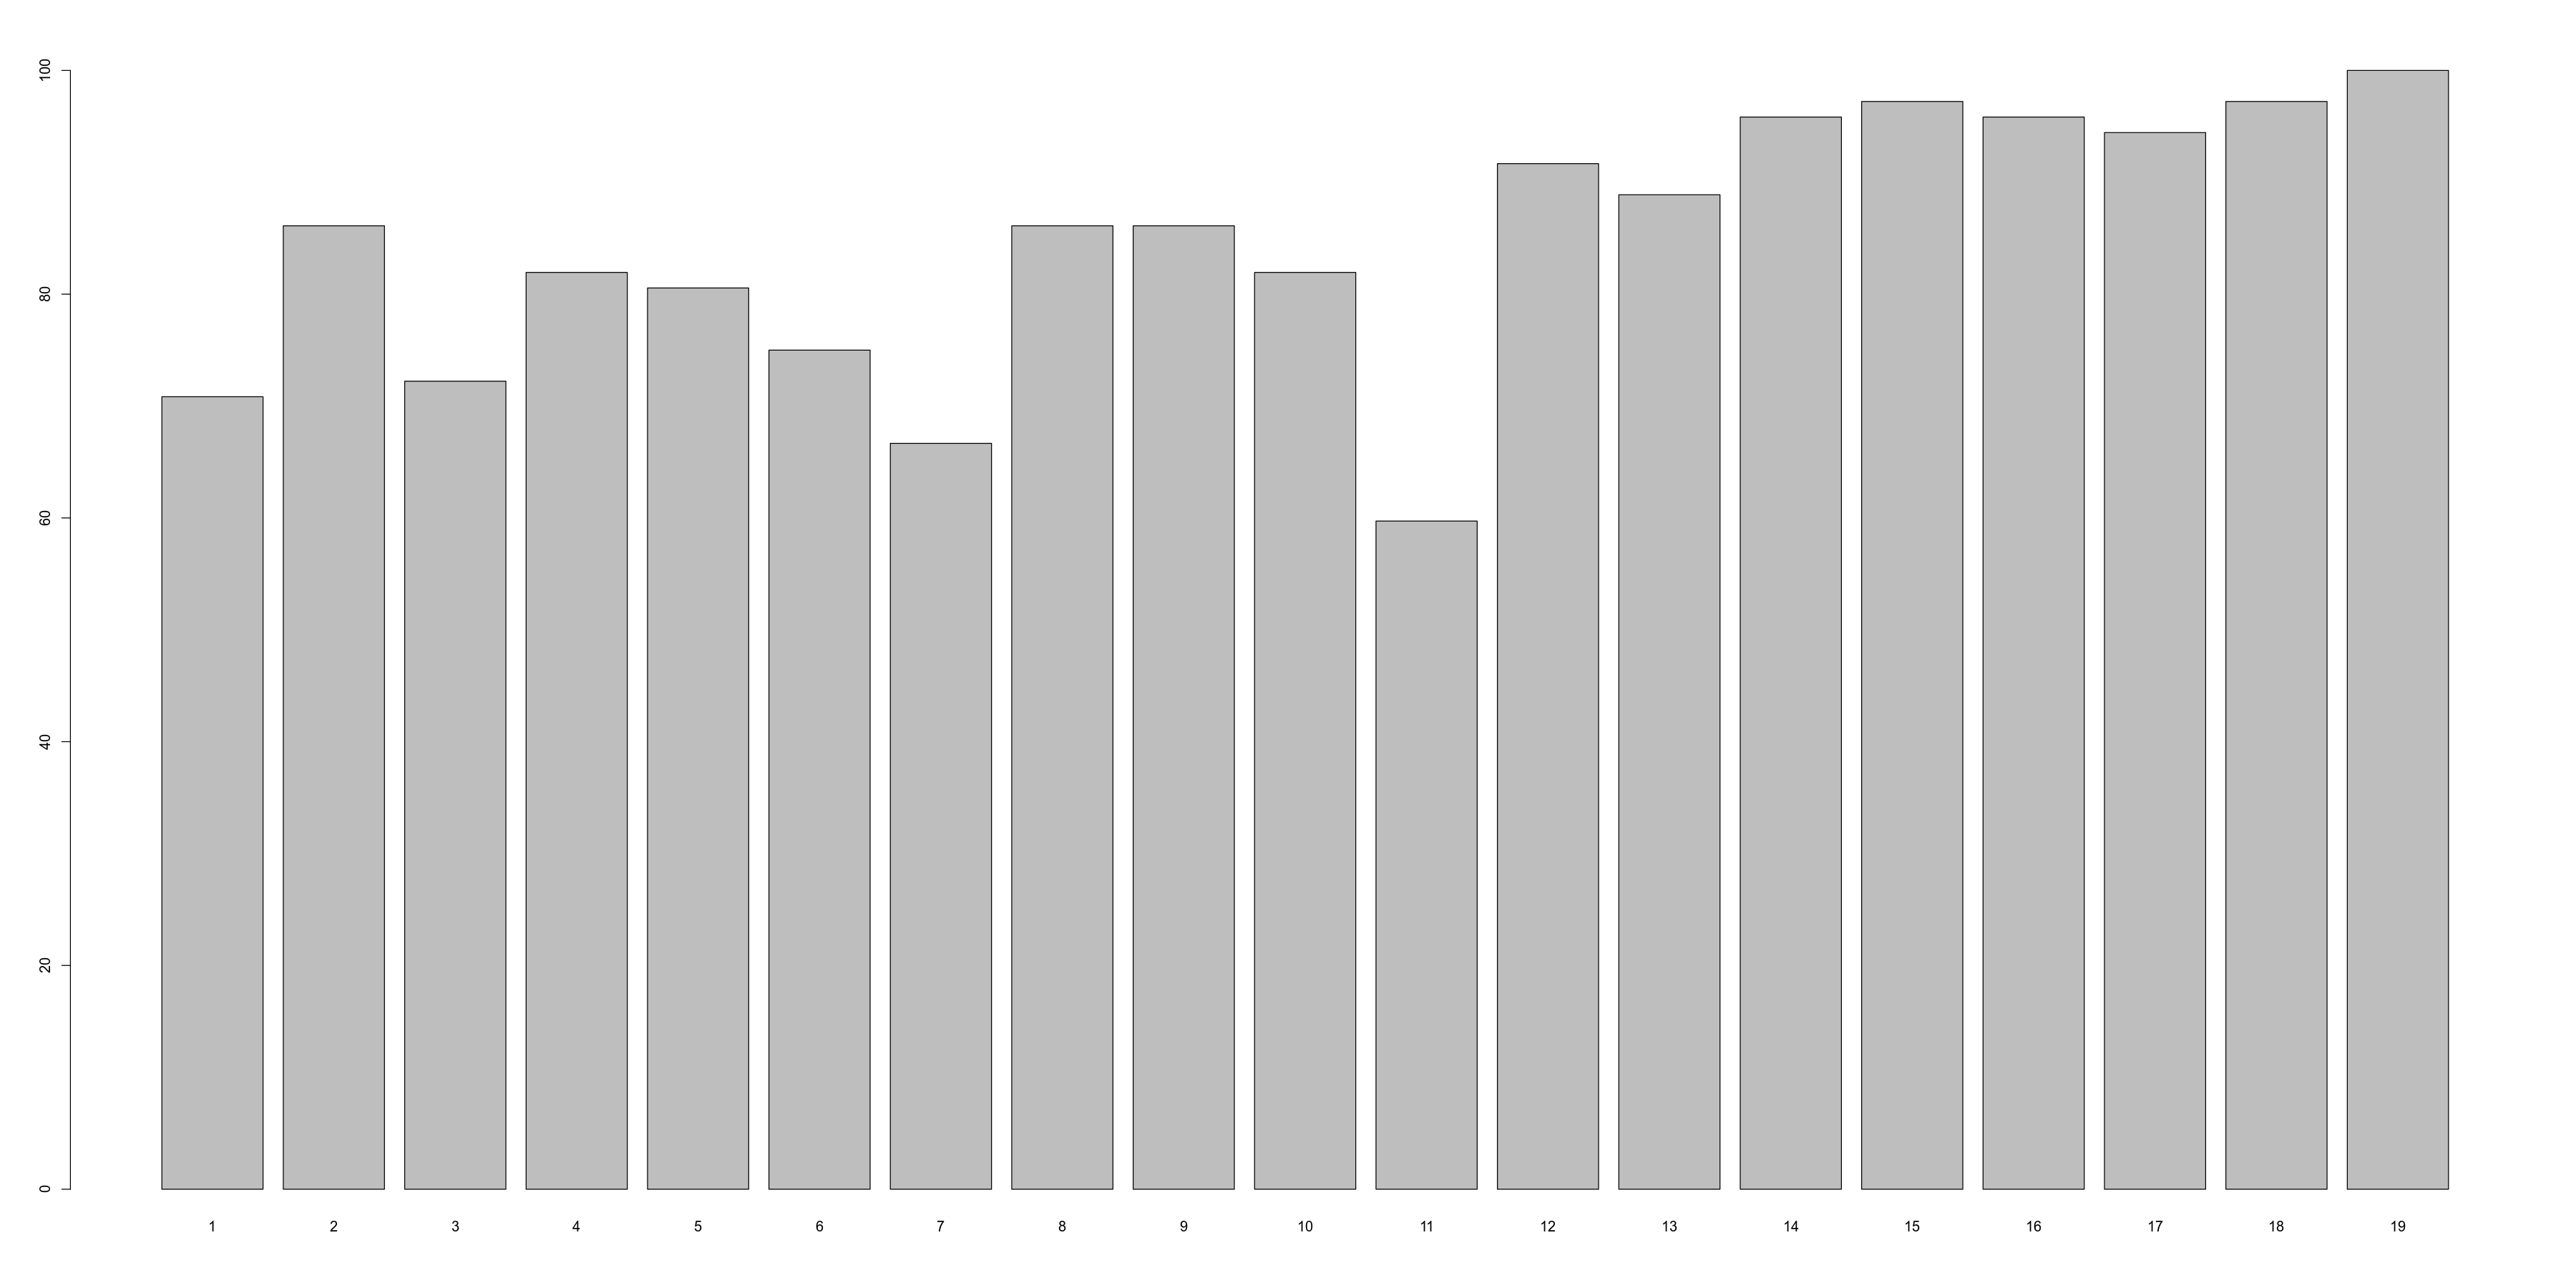

In [177]:
barplot(df_count_chr$Percent, names.arg=df_count_chr$FITC.Rank)